# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

# <a id='index'>Index</a>

+ <a href='#data_analysis'>1. Data Analysis</a>
    + <a href='#info_about_data'>1.1 Info about data:</a>
+ <a href='#noise_removal'>2. Noise removal and Normalization</a>
+ <a href='#training_and_validation'>3. Training and Validation</a>
+ <a href='#testing'>4 Testing</a>

In [25]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# <a id='data_analysis'>1. Data analysis</a>
<a href='#index'>Go back to Index</a>

In [26]:
train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

df = pd.read_csv(train_file,sep=" ",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [27]:
#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Dataset statistics  for each parameter

In [28]:
df.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## <a id='info_about_data'>1.1 Info about data:</a>
- Section-0 is MachineID
- Section-1 is time in, Cycles
- Section-2...4 is Opertional Settings
- Section-5...25 is sensor's data 


- Data Set: FD001
- Train trjectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

In [29]:
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [30]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


From the above vizulization its clear that 
- Section-4 (Oprational Setting-3)
- Section-5 (Sensor-1)
- Section-9  (Sensor-5)
- Section-14 (Sensor-10)
- Section-20 (Sensor-16)
- Section-22 (Sensor-18)
- Section-23 (Sensor-19)

Does not play a vital role in variation of data and there std is also almost 0 so, these sensor data is useless for us hence, we can drop this coloumn data

In [31]:
#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

In [32]:
df.head()

,Section-1,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


# <a id='noise_removal'>2. Noise removal and Normalization</a>
<a href='#index'>Go back to Index</a>

In [33]:
print(type(df))
gen = MinMaxScaler(feature_range=(0, 1))
df = gen.fit_transform(df)
df = pd.DataFrame(df)
#df = df.rolling(20).mean()
pt = PowerTransformer()
df = pt.fit_transform(df)

<class 'pandas.core.frame.DataFrame'>


In [34]:
df=np.nan_to_num(df)

In [35]:
df

array([[-1.84688137, -0.31975365, -1.3916867 , ..., -0.76399955,
         1.42665355,  1.24248381],
       [-1.82422371,  0.87202066, -1.03174892, ..., -0.76399955,
         1.03734696,  1.29226848],
       [-1.80166973, -1.9503069 ,  1.01385485, ..., -2.35059786,
         0.72414823,  0.465476  ],
       ...,
       [ 1.25582441,  0.18308976,  0.01311911, ...,  2.66650739,
        -1.90974435, -2.75272539],
       [ 1.26682846, -0.50209065,  1.01385485, ...,  1.14636389,
        -2.49938469, -1.91568423],
       [ 1.27779988, -1.45465135, -1.75831429, ...,  1.68933126,
        -2.19492018, -1.99819889]])

In [36]:
# grouping w.r.t MID (Machine ID)
# col_names = df.columns
# def grouping(datafile, mid_series):
#     data = [x for x in datafile.groupby(mid_series)]
#     return data 

# <a id='training_and_validation'>3. Training and Validation using LSTM</a>
<a href='#index'>Go back to Index</a>

In [79]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

RUL_df().head()

,rul
0,192
1,191
2,190
3,189
4,188


In [80]:
X_train = np.array(df)

y_train = np.array(RUL_df()).reshape(-1,1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 


print(X_train.shape,y_train.shape)

(20631, 17) (20631, 1)


In [82]:
X_train_new = []
y_train_new = []
i = 0
count = 0
while i < len(X_train):
    temp_x = []
    temp_y = []
    j = int(max_cycles[count])
    count = count+1
    if j == 0:
        break
    while j!=0:
        temp_x.append(X_train[i])
        temp_y.append(int(y_train[i][0]))
        i=i+1
        j=j-1
    X_train_new.append(temp_x)
    y_train_new.append(temp_y)


In [83]:
print(y_train_new[0])

[192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [84]:
def create_dataset(X, look_back=20):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

for i in range(len(X_train_new)):
    X_train_new[i] = create_dataset(X_train_new[i])
    y_train_new[i] = y_train_new[i][21:]
    y_train_new[i] = np.array(y_train_new[i])

In [85]:
def build_model(layers):
        #d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        #model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        #model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mean_squared_error',optimizer='adam')
        return model

In [86]:
model = build_model([17,20])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 20, 128)           74752     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 125,217
Trainable params: 125,217
Non-trainable params: 0
_________________________________________________________________
None


In [124]:
X_train_new[0].shape

(171, 20, 17)

--------------------------------------- Current Engine : 1  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 59ms/step - loss: 2923.5439 - val_loss: 2204.5398
Epoch 2/75
1/1 [==============================] - 0s 63ms/step - loss: 2897.5449 - val_loss: 2238.3762
Epoch 3/75
1/1 [==============================] - 0s 55ms/step - loss: 2872.6978 - val_loss: 2271.3970
Epoch 4/75
1/1 [==============================] - 0s 55ms/step - loss: 2848.8994 - val_loss: 2303.6699
Epoch 5/75
1/1 [==============================] - 0s 56ms/step - loss: 2826.0598 - val_loss: 2335.2566
Epoch 6/75
1/1 [==============================] - 0s 59ms/step - loss: 2804.0989 - val_loss: 2366.2183
Epoch 7/75
1/1 [==============================] - 0s 57ms/step - loss: 2782.9419 - val_loss: 2396.6062
Epoch 8/75
1/1 [==============================] - 0s 63ms/step - loss: 2762.5249 - val_loss: 2426.4712
Epoch 9/75
1/1 [==============================] - 0s 59ms/step - loss: 2742.

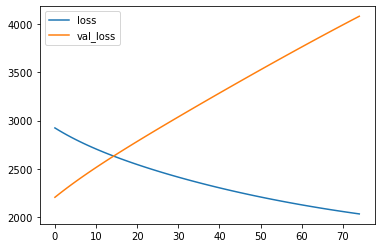

--------------------------------------- Current Engine : 2  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 96ms/step - loss: 9306.2480 - val_loss: 3997.6375
Epoch 2/75
1/1 [==============================] - 0s 52ms/step - loss: 9273.9531 - val_loss: 4031.6343
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 9235.3721 - val_loss: 4070.8508
Epoch 4/75
1/1 [==============================] - 0s 63ms/step - loss: 9191.2607 - val_loss: 4114.8101
Epoch 5/75
1/1 [==============================] - 0s 63ms/step - loss: 9142.3057 - val_loss: 4163.0972
Epoch 6/75
1/1 [==============================] - 0s 61ms/step - loss: 9089.1201 - val_loss: 4215.3418
Epoch 7/75
1/1 [==============================] - 0s 61ms/step - loss: 9032.2598 - val_loss: 4271.2095
Epoch 8/75
1/1 [==============================] - 0s 59ms/step - loss: 8972.2256 - val_loss: 4330.4014
Epoch 9/75
1/1 [==============================] - 0s 55ms/step - loss: 8909.

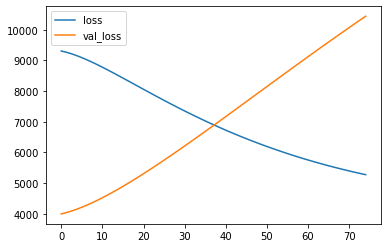

--------------------------------------- Current Engine : 3  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 67ms/step - loss: 2427.4192 - val_loss: 12122.4346
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 2450.0811 - val_loss: 12186.9453
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 2468.2739 - val_loss: 12236.3828
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 2482.2998 - val_loss: 12272.0703
Epoch 5/75
1/1 [==============================] - 0s 41ms/step - loss: 2492.4685 - val_loss: 12295.2500
Epoch 6/75
1/1 [==============================] - 0s 41ms/step - loss: 2499.0940 - val_loss: 12307.0986
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 2502.4866 - val_loss: 12308.6992
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 2502.9453 - val_loss: 12301.0781
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - los

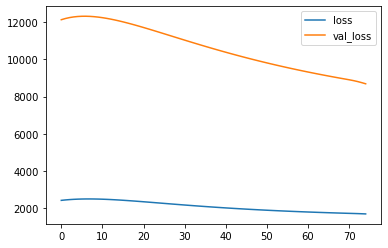

--------------------------------------- Current Engine : 4  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 76ms/step - loss: 1743.1517 - val_loss: 8441.8926
Epoch 2/75
1/1 [==============================] - 0s 34ms/step - loss: 1737.6569 - val_loss: 8371.2129
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 1731.9783 - val_loss: 8295.7510
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 1726.1648 - val_loss: 8223.9893
Epoch 5/75
1/1 [==============================] - 0s 34ms/step - loss: 1720.8986 - val_loss: 8166.0552
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 1716.8712 - val_loss: 8123.3135
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 1714.0374 - val_loss: 8090.9482
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 1711.9667 - val_loss: 8064.4688
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 1710.

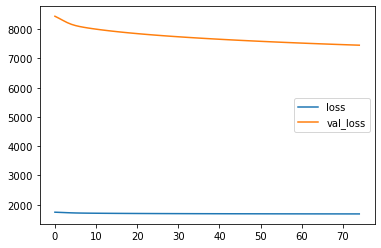

--------------------------------------- Current Engine : 5  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 59ms/step - loss: 5611.0088 - val_loss: 6524.3965
Epoch 2/75
1/1 [==============================] - 0s 45ms/step - loss: 5608.6187 - val_loss: 6536.5840
Epoch 3/75
1/1 [==============================] - 0s 45ms/step - loss: 5601.9312 - val_loss: 6555.8286
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 5591.4067 - val_loss: 6581.4414
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 5577.4697 - val_loss: 6612.8062
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 5560.5088 - val_loss: 6649.3706
Epoch 7/75
1/1 [==============================] - 0s 53ms/step - loss: 5540.8833 - val_loss: 6690.6392
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 5518.9204 - val_loss: 6736.1724
Epoch 9/75
1/1 [==============================] - 0s 39ms/step - loss: 5494.

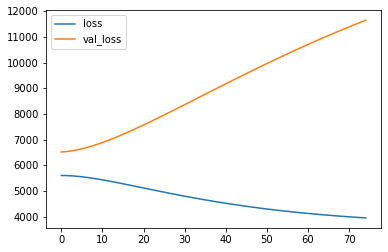

--------------------------------------- Current Engine : 6  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 81ms/step - loss: 8734.1738 - val_loss: 11508.9111
Epoch 2/75
1/1 [==============================] - 0s 37ms/step - loss: 2486.5618 - val_loss: 10379.7051
Epoch 3/75
1/1 [==============================] - 0s 52ms/step - loss: 2468.6104 - val_loss: 9436.6592
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 2378.7510 - val_loss: 8555.3896
Epoch 5/75
1/1 [==============================] - 0s 41ms/step - loss: 2218.4431 - val_loss: 6145.5146
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 1957.2098 - val_loss: 2414.2864
Epoch 7/75
1/1 [==============================] - 0s 38ms/step - loss: 1627.2046 - val_loss: 422.7830
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 1122.9006 - val_loss: 213.9120
Epoch 9/75
1/1 [==============================] - 0s 41ms/step - loss: 836.8

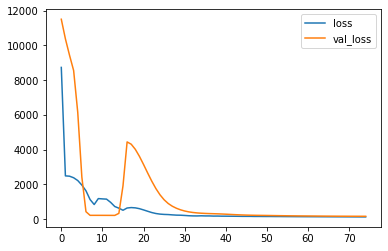

--------------------------------------- Current Engine : 7  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 71ms/step - loss: 2755.0032 - val_loss: 193.4387
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 2729.1426 - val_loss: 193.7115
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 2616.5452 - val_loss: 184.2319
Epoch 4/75
1/1 [==============================] - 0s 50ms/step - loss: 2472.3892 - val_loss: 183.2311
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 2193.6118 - val_loss: 187.6180
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 2140.2622 - val_loss: 198.2010
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 2275.9915 - val_loss: 213.7461
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 2089.0803 - val_loss: 233.5958
Epoch 9/75
1/1 [==============================] - 0s 48ms/step - loss: 2023.0323 - v

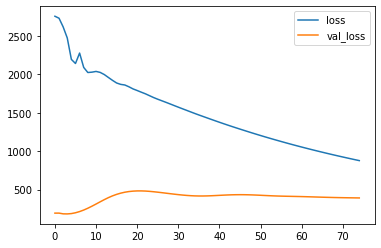

--------------------------------------- Current Engine : 8  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 68ms/step - loss: 749.3544 - val_loss: 514.3589
Epoch 2/75
1/1 [==============================] - 0s 34ms/step - loss: 226.7760 - val_loss: 417.7065
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 224.3269 - val_loss: 331.0724
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 317.8017 - val_loss: 277.1103
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 343.0508 - val_loss: 256.2342
Epoch 6/75
1/1 [==============================] - 0s 34ms/step - loss: 235.1876 - val_loss: 256.2533
Epoch 7/75
1/1 [==============================] - 0s 36ms/step - loss: 122.9886 - val_loss: 264.9068
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 118.7958 - val_loss: 273.2153
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 163.2640 - val_loss: 

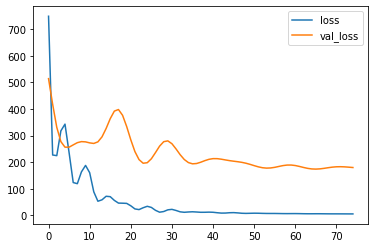

--------------------------------------- Current Engine : 9  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 69ms/step - loss: 3163.9109 - val_loss: 946.5172
Epoch 2/75
1/1 [==============================] - 0s 56ms/step - loss: 2003.1556 - val_loss: 812.8912
Epoch 3/75
1/1 [==============================] - 0s 62ms/step - loss: 939.3282 - val_loss: 425.2820
Epoch 4/75
1/1 [==============================] - 0s 62ms/step - loss: 2817.9431 - val_loss: 556.3079
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 803.3688 - val_loss: 481.2002
Epoch 6/75
1/1 [==============================] - 0s 37ms/step - loss: 547.6744 - val_loss: 360.9954
Epoch 7/75
1/1 [==============================] - 0s 37ms/step - loss: 302.8903 - val_loss: 262.1312
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 277.7938 - val_loss: 218.7405
Epoch 9/75
1/1 [==============================] - 0s 34ms/step - loss: 298.8852 - val_los

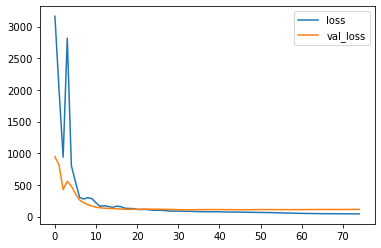

--------------------------------------- Current Engine : 10  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 84ms/step - loss: 303.4254 - val_loss: 96.1387
Epoch 2/75
1/1 [==============================] - 0s 52ms/step - loss: 279.0453 - val_loss: 103.5370
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 252.2946 - val_loss: 113.9285
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 234.2970 - val_loss: 126.9732
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 220.5730 - val_loss: 142.2706
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 205.9425 - val_loss: 159.3421
Epoch 7/75
1/1 [==============================] - 0s 37ms/step - loss: 194.7510 - val_loss: 177.6500
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 190.2754 - val_loss: 196.6470
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 187.1676 - val_loss: 

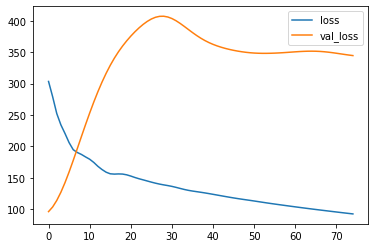

--------------------------------------- Current Engine : 11  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 64ms/step - loss: 1067.3607 - val_loss: 362.4341
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 361.6573 - val_loss: 367.7130
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 540.5463 - val_loss: 371.9542
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 763.9699 - val_loss: 374.3701
Epoch 5/75
1/1 [==============================] - 0s 35ms/step - loss: 781.7230 - val_loss: 374.4716
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 647.9710 - val_loss: 373.0161
Epoch 7/75
1/1 [==============================] - 0s 38ms/step - loss: 477.0196 - val_loss: 371.3385
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 356.2709 - val_loss: 371.2702
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 467.1379 - val_loss

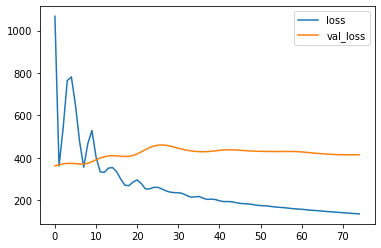

--------------------------------------- Current Engine : 12  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 85ms/step - loss: 646.8205 - val_loss: 467.6562
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 394.9030 - val_loss: 503.3457
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 150.5230 - val_loss: 524.7402
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 55.5408 - val_loss: 513.1937
Epoch 5/75
1/1 [==============================] - 0s 35ms/step - loss: 159.7231 - val_loss: 468.1657
Epoch 6/75
1/1 [==============================] - 0s 51ms/step - loss: 222.8144 - val_loss: 402.9658
Epoch 7/75
1/1 [==============================] - 0s 34ms/step - loss: 181.3615 - val_loss: 333.9915
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 108.6212 - val_loss: 273.4733
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 47.4097 - val_loss: 2

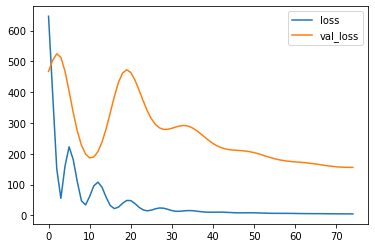

--------------------------------------- Current Engine : 13  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 70ms/step - loss: 100.2875 - val_loss: 290.7568
Epoch 2/75
1/1 [==============================] - 0s 33ms/step - loss: 76.5664 - val_loss: 298.7527
Epoch 3/75
1/1 [==============================] - 0s 34ms/step - loss: 52.5155 - val_loss: 310.3487
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 42.0502 - val_loss: 325.4053
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 45.5177 - val_loss: 343.6080
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 51.6075 - val_loss: 364.2018
Epoch 7/75
1/1 [==============================] - 0s 33ms/step - loss: 53.3961 - val_loss: 385.7657
Epoch 8/75
1/1 [==============================] - 0s 34ms/step - loss: 47.3715 - val_loss: 406.0955
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 34.8318 - val_loss: 422.408

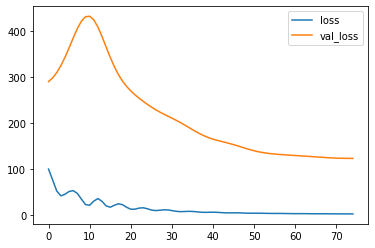

--------------------------------------- Current Engine : 14  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 78ms/step - loss: 474.7045 - val_loss: 111.3379
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 299.0744 - val_loss: 143.0049
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 111.6621 - val_loss: 190.7670
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 38.1347 - val_loss: 245.4662
Epoch 5/75
1/1 [==============================] - 0s 33ms/step - loss: 90.9685 - val_loss: 280.4304
Epoch 6/75
1/1 [==============================] - 0s 33ms/step - loss: 169.7727 - val_loss: 283.8804
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 165.1551 - val_loss: 264.3514
Epoch 8/75
1/1 [==============================] - 0s 34ms/step - loss: 98.3613 - val_loss: 232.0699
Epoch 9/75
1/1 [==============================] - 0s 39ms/step - loss: 47.4198 - val_loss: 198

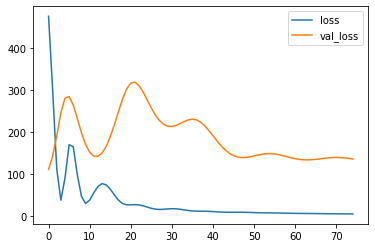

--------------------------------------- Current Engine : 15  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 1976.6007 - val_loss: 297.5451
Epoch 2/75
1/1 [==============================] - 0s 56ms/step - loss: 1542.9034 - val_loss: 256.2538
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 950.3981 - val_loss: 206.2095
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 523.8649 - val_loss: 153.6394
Epoch 5/75
1/1 [==============================] - 0s 38ms/step - loss: 489.8567 - val_loss: 103.0133
Epoch 6/75
1/1 [==============================] - 0s 37ms/step - loss: 574.0535 - val_loss: 62.7091
Epoch 7/75
1/1 [==============================] - 0s 38ms/step - loss: 484.4954 - val_loss: 37.0587
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 218.2017 - val_loss: 24.4210
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 66.3463 - val_loss: 2

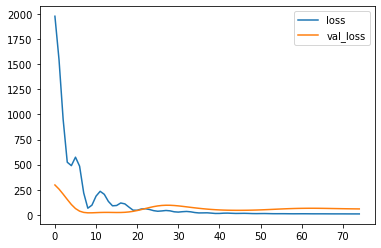

--------------------------------------- Current Engine : 16  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 69ms/step - loss: 4886.4351 - val_loss: 67.4408
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 4047.2634 - val_loss: 108.7988
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 2907.1101 - val_loss: 232.2341
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 1811.8707 - val_loss: 517.8474
Epoch 5/75
1/1 [==============================] - 0s 35ms/step - loss: 1018.3356 - val_loss: 992.6936
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 550.3391 - val_loss: 1564.2058
Epoch 7/75
1/1 [==============================] - 0s 40ms/step - loss: 486.0602 - val_loss: 2117.6755
Epoch 8/75
1/1 [==============================] - 0s 41ms/step - loss: 675.5752 - val_loss: 2557.8782
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 797.3945 - va

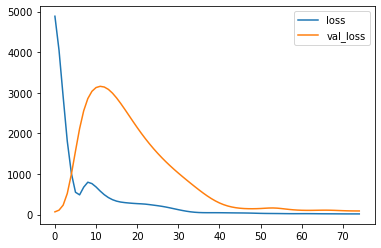

--------------------------------------- Current Engine : 17  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 81ms/step - loss: 2002.1877 - val_loss: 871.5851
Epoch 2/75
1/1 [==============================] - 0s 61ms/step - loss: 1432.2120 - val_loss: 863.9659
Epoch 3/75
1/1 [==============================] - 0s 58ms/step - loss: 930.7848 - val_loss: 820.8598
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 824.3268 - val_loss: 737.9655
Epoch 5/75
1/1 [==============================] - 0s 46ms/step - loss: 792.8686 - val_loss: 628.8666
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 864.7062 - val_loss: 497.1156
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 970.4821 - val_loss: 369.3936
Epoch 8/75
1/1 [==============================] - 0s 41ms/step - loss: 989.6719 - val_loss: 264.1856
Epoch 9/75
1/1 [==============================] - 0s 38ms/step - loss: 937.5262 - val_los

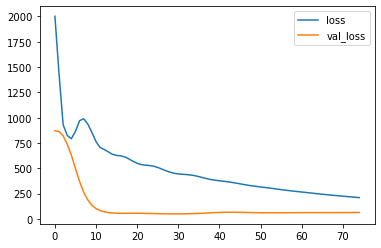

--------------------------------------- Current Engine : 18  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 65ms/step - loss: 3667.1257 - val_loss: 490.5670
Epoch 2/75
1/1 [==============================] - 0s 52ms/step - loss: 2898.9541 - val_loss: 423.8431
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 1706.9109 - val_loss: 353.1853
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 504.4303 - val_loss: 285.4175
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 99.2528 - val_loss: 228.9794
Epoch 6/75
1/1 [==============================] - 0s 34ms/step - loss: 201.2342 - val_loss: 189.9499
Epoch 7/75
1/1 [==============================] - 0s 41ms/step - loss: 561.5641 - val_loss: 168.0019
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 573.9874 - val_loss: 157.4112
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 236.7914 - val_los

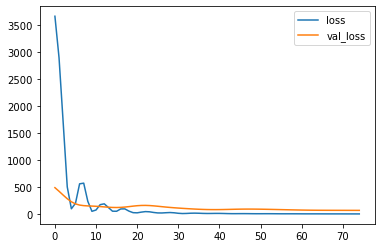

--------------------------------------- Current Engine : 19  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 71ms/step - loss: 5211.5039 - val_loss: 503.0947
Epoch 2/75
1/1 [==============================] - 0s 35ms/step - loss: 3743.1296 - val_loss: 267.1919
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 1823.6594 - val_loss: 131.8083
Epoch 4/75
1/1 [==============================] - 0s 31ms/step - loss: 764.4123 - val_loss: 68.2957
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 264.6570 - val_loss: 41.1491
Epoch 6/75
1/1 [==============================] - 0s 36ms/step - loss: 98.4352 - val_loss: 30.8057
Epoch 7/75
1/1 [==============================] - 0s 34ms/step - loss: 132.3224 - val_loss: 27.5666
Epoch 8/75
1/1 [==============================] - 0s 33ms/step - loss: 280.6130 - val_loss: 27.2257
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 427.5768 - val_loss: 28

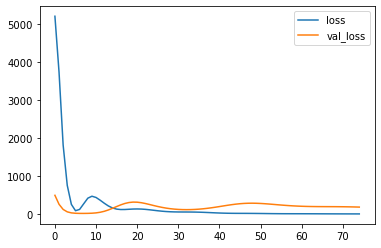

--------------------------------------- Current Engine : 20  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 71ms/step - loss: 1724.4355 - val_loss: 82.0163
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 1606.3059 - val_loss: 89.8846
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 1385.0265 - val_loss: 104.7737
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 1032.2239 - val_loss: 129.7832
Epoch 5/75
1/1 [==============================] - 0s 38ms/step - loss: 824.5352 - val_loss: 168.7473
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 651.2123 - val_loss: 226.7144
Epoch 7/75
1/1 [==============================] - 0s 38ms/step - loss: 517.8260 - val_loss: 309.6174
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 437.3766 - val_loss: 416.1055
Epoch 9/75
1/1 [==============================] - 0s 56ms/step - loss: 398.6552 - val_los

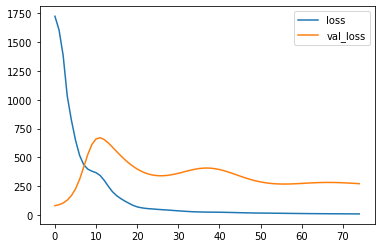

--------------------------------------- Current Engine : 21  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 71ms/step - loss: 3552.0381 - val_loss: 462.6552
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 2096.8889 - val_loss: 422.1956
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 1331.9017 - val_loss: 371.5277
Epoch 4/75
1/1 [==============================] - 0s 33ms/step - loss: 1044.0007 - val_loss: 317.4471
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 849.8499 - val_loss: 266.3900
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 744.1289 - val_loss: 221.6955
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 654.8832 - val_loss: 184.7655
Epoch 8/75
1/1 [==============================] - 0s 34ms/step - loss: 552.2856 - val_loss: 155.3781
Epoch 9/75
1/1 [==============================] - 0s 34ms/step - loss: 431.5645 - val_l

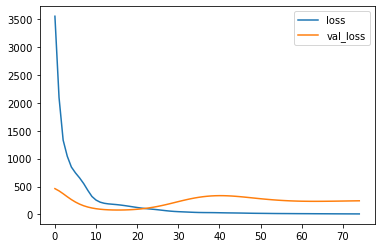

--------------------------------------- Current Engine : 22  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 71ms/step - loss: 1426.4103 - val_loss: 257.4701
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 1181.6266 - val_loss: 296.6697
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 766.3118 - val_loss: 352.1465
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 366.4352 - val_loss: 420.4020
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 115.1039 - val_loss: 494.8673
Epoch 6/75
1/1 [==============================] - 0s 34ms/step - loss: 57.5259 - val_loss: 565.8774
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 163.8288 - val_loss: 621.9427
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 320.0796 - val_loss: 653.0676
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 411.1276 - val_loss

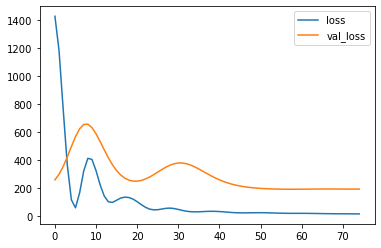

--------------------------------------- Current Engine : 23  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 69ms/step - loss: 2003.1957 - val_loss: 279.7724
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 1655.4232 - val_loss: 247.2728
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 1137.5896 - val_loss: 210.0557
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 641.5258 - val_loss: 174.0566
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 329.5410 - val_loss: 142.6411
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 201.2243 - val_loss: 117.1981
Epoch 7/75
1/1 [==============================] - 0s 36ms/step - loss: 167.5802 - val_loss: 97.7694
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 176.0226 - val_loss: 83.6510
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 199.8613 - val_loss

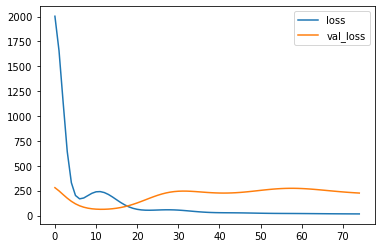

--------------------------------------- Current Engine : 24  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 1742.8168 - val_loss: 346.4971
Epoch 2/75
1/1 [==============================] - 0s 48ms/step - loss: 908.2766 - val_loss: 321.8392
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 893.0507 - val_loss: 291.8444
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 804.8483 - val_loss: 259.2857
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 530.4077 - val_loss: 226.7224
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 255.9207 - val_loss: 196.0891
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 186.5313 - val_loss: 168.8060
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 251.1983 - val_loss: 145.6816
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 309.6798 - val_loss

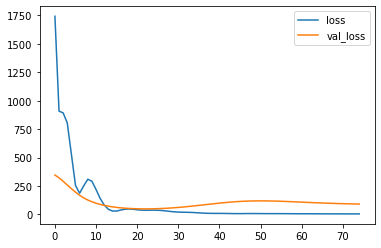

--------------------------------------- Current Engine : 25  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 55ms/step - loss: 5391.0742 - val_loss: 79.7150
Epoch 2/75
1/1 [==============================] - 0s 35ms/step - loss: 4987.4629 - val_loss: 87.6271
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 4355.7910 - val_loss: 103.7917
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 3639.9851 - val_loss: 132.5580
Epoch 5/75
1/1 [==============================] - 0s 39ms/step - loss: 2944.7283 - val_loss: 178.9811
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 2330.1440 - val_loss: 248.1658
Epoch 7/75
1/1 [==============================] - 0s 36ms/step - loss: 1821.2373 - val_loss: 343.9435
Epoch 8/75
1/1 [==============================] - ETA: 0s - loss: 1422.07 - 0s 36ms/step - loss: 1422.0780 - val_loss: 466.9941
Epoch 9/75
1/1 [==============================] - 0s 36ms/s

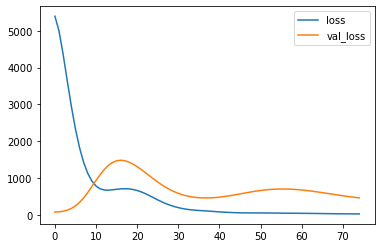

--------------------------------------- Current Engine : 26  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 78ms/step - loss: 61.5974 - val_loss: 569.0735
Epoch 2/75
1/1 [==============================] - 0s 37ms/step - loss: 59.0409 - val_loss: 545.9475
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 55.6439 - val_loss: 520.9293
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 52.0310 - val_loss: 495.0993
Epoch 5/75
1/1 [==============================] - 0s 34ms/step - loss: 48.6989 - val_loss: 469.4066
Epoch 6/75
1/1 [==============================] - 0s 37ms/step - loss: 45.9308 - val_loss: 444.6350
Epoch 7/75
1/1 [==============================] - 0s 34ms/step - loss: 43.8015 - val_loss: 421.3895
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 42.2340 - val_loss: 400.1013
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 41.0725 - val_loss: 381.0455

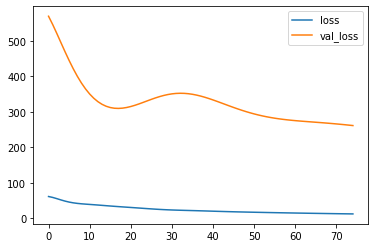

--------------------------------------- Current Engine : 27  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 69ms/step - loss: 1970.3110 - val_loss: 367.3482
Epoch 2/75
1/1 [==============================] - 0s 36ms/step - loss: 1600.3740 - val_loss: 343.2434
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 1030.4601 - val_loss: 313.5098
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 657.8650 - val_loss: 281.2527
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 468.4680 - val_loss: 249.0880
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 341.1761 - val_loss: 218.9707
Epoch 7/75
1/1 [==============================] - 0s 33ms/step - loss: 239.0130 - val_loss: 192.0788
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 160.0476 - val_loss: 168.9672
Epoch 9/75
1/1 [==============================] - 0s 36ms/step - loss: 105.9117 - val_lo

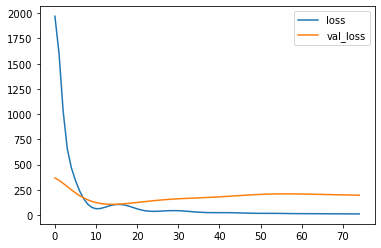

--------------------------------------- Current Engine : 28  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 84ms/step - loss: 969.4055 - val_loss: 243.1571
Epoch 2/75
1/1 [==============================] - 0s 36ms/step - loss: 857.4885 - val_loss: 236.9757
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 706.3700 - val_loss: 228.9484
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 547.9584 - val_loss: 219.5878
Epoch 5/75
1/1 [==============================] - 0s 33ms/step - loss: 379.7373 - val_loss: 209.3509
Epoch 6/75
1/1 [==============================] - 0s 34ms/step - loss: 235.0730 - val_loss: 198.6571
Epoch 7/75
1/1 [==============================] - 0s 36ms/step - loss: 145.1858 - val_loss: 187.9715
Epoch 8/75
1/1 [==============================] - 0s 35ms/step - loss: 139.7993 - val_loss: 177.7416
Epoch 9/75
1/1 [==============================] - 0s 38ms/step - loss: 148.6578 - val_loss:

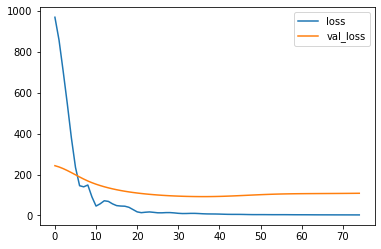

--------------------------------------- Current Engine : 29  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 66ms/step - loss: 760.3226 - val_loss: 127.9493
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 678.3573 - val_loss: 134.8019
Epoch 3/75
1/1 [==============================] - 0s 34ms/step - loss: 559.7367 - val_loss: 144.2473
Epoch 4/75
1/1 [==============================] - 0s 55ms/step - loss: 441.6779 - val_loss: 155.7458
Epoch 5/75
1/1 [==============================] - 0s 51ms/step - loss: 342.3532 - val_loss: 168.6679
Epoch 6/75
1/1 [==============================] - 0s 48ms/step - loss: 266.9806 - val_loss: 182.2777
Epoch 7/75
1/1 [==============================] - 0s 40ms/step - loss: 213.9566 - val_loss: 195.7567
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 178.6620 - val_loss: 208.2562
Epoch 9/75
1/1 [==============================] - 0s 36ms/step - loss: 156.4084 - val_loss:

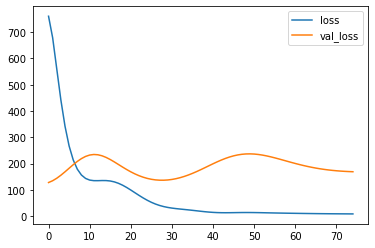

--------------------------------------- Current Engine : 30  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 91ms/step - loss: 699.5475 - val_loss: 194.9753
Epoch 2/75
1/1 [==============================] - 0s 52ms/step - loss: 631.3015 - val_loss: 189.9563
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 553.9546 - val_loss: 183.1724
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 496.7892 - val_loss: 174.9488
Epoch 5/75
1/1 [==============================] - 0s 35ms/step - loss: 448.5292 - val_loss: 165.6124
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 396.3257 - val_loss: 155.5273
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 335.4810 - val_loss: 145.0883
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 269.8969 - val_loss: 134.7246
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 211.5783 - val_loss:

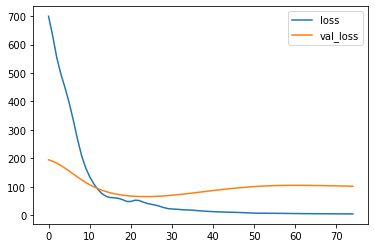

--------------------------------------- Current Engine : 31  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 83ms/step - loss: 978.6641 - val_loss: 77.2934
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 646.7126 - val_loss: 78.0829
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 343.8719 - val_loss: 79.4091
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 257.6100 - val_loss: 81.3447
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 307.0822 - val_loss: 83.8989
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 380.3228 - val_loss: 87.0728
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 425.8977 - val_loss: 90.8551
Epoch 8/75
1/1 [==============================] - 0s 65ms/step - loss: 424.8865 - val_loss: 95.2139
Epoch 9/75
1/1 [==============================] - 0s 55ms/step - loss: 381.0089 - val_loss: 100.109

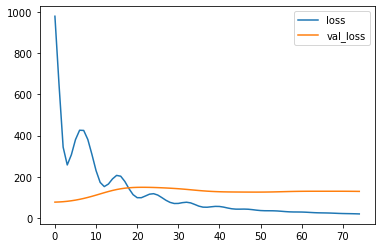

--------------------------------------- Current Engine : 32  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 69ms/step - loss: 1517.5725 - val_loss: 135.5374
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 1355.6317 - val_loss: 156.3247
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 1095.9612 - val_loss: 189.1322
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 817.9128 - val_loss: 235.9913
Epoch 5/75
1/1 [==============================] - 0s 39ms/step - loss: 566.8912 - val_loss: 298.8280
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 356.1325 - val_loss: 379.3839
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 207.4086 - val_loss: 485.2661
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 129.0840 - val_loss: 637.1389
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 105.4822 - val_lo

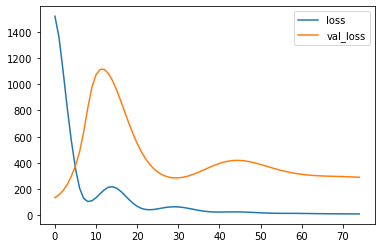

--------------------------------------- Current Engine : 33  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 100ms/step - loss: 1481.0746 - val_loss: 866.3277
Epoch 2/75
1/1 [==============================] - 0s 54ms/step - loss: 1109.5699 - val_loss: 847.9789
Epoch 3/75
1/1 [==============================] - 0s 58ms/step - loss: 647.7289 - val_loss: 820.1105
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 362.9260 - val_loss: 782.2849
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 394.2898 - val_loss: 734.2585
Epoch 6/75
1/1 [==============================] - 0s 59ms/step - loss: 503.6699 - val_loss: 679.1962
Epoch 7/75
1/1 [==============================] - 0s 52ms/step - loss: 543.7183 - val_loss: 620.5672
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 502.2776 - val_loss: 561.0528
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 399.0354 - val_lo

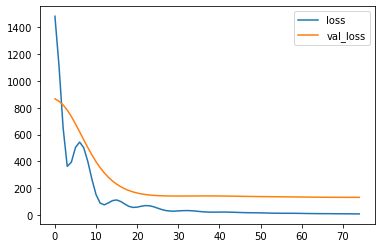

--------------------------------------- Current Engine : 34  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 911.4034 - val_loss: 86.8303
Epoch 2/75
1/1 [==============================] - 0s 40ms/step - loss: 627.8049 - val_loss: 94.4909
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 405.1534 - val_loss: 105.0974
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 281.8991 - val_loss: 118.7810
Epoch 5/75
1/1 [==============================] - 0s 34ms/step - loss: 198.8456 - val_loss: 135.7346
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 142.4334 - val_loss: 156.1023
Epoch 7/75
1/1 [==============================] - 0s 34ms/step - loss: 110.1008 - val_loss: 179.8979
Epoch 8/75
1/1 [==============================] - 0s 35ms/step - loss: 94.6211 - val_loss: 206.9393
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 87.1526 - val_loss: 236

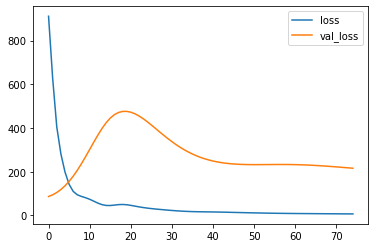

--------------------------------------- Current Engine : 35  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 109ms/step - loss: 343.5013 - val_loss: 250.6248
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 294.4026 - val_loss: 244.1165
Epoch 3/75
1/1 [==============================] - 0s 34ms/step - loss: 219.1112 - val_loss: 235.9194
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 148.3220 - val_loss: 226.5398
Epoch 5/75
1/1 [==============================] - 0s 39ms/step - loss: 120.2198 - val_loss: 216.4324
Epoch 6/75
1/1 [==============================] - 0s 75ms/step - loss: 136.9183 - val_loss: 205.9945
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 147.5936 - val_loss: 195.6000
Epoch 8/75
1/1 [==============================] - 0s 34ms/step - loss: 128.0786 - val_loss: 185.5645
Epoch 9/75
1/1 [==============================] - 0s 33ms/step - loss: 92.1242 - val_loss:

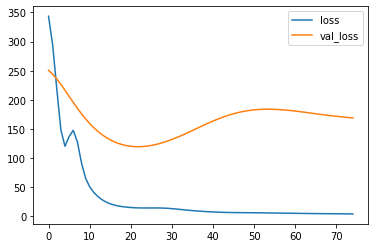

--------------------------------------- Current Engine : 36  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 21.0780 - val_loss: 236.3820
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 20.3432 - val_loss: 233.1905
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 19.1291 - val_loss: 229.1916
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 17.6796 - val_loss: 224.6118
Epoch 5/75
1/1 [==============================] - 0s 46ms/step - loss: 16.2348 - val_loss: 219.6651
Epoch 6/75
1/1 [==============================] - 0s 37ms/step - loss: 14.9736 - val_loss: 214.5436
Epoch 7/75
1/1 [==============================] - 0s 33ms/step - loss: 13.9797 - val_loss: 209.4112
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 13.2421 - val_loss: 204.4024
Epoch 9/75
1/1 [==============================] - 0s 36ms/step - loss: 12.6866 - val_loss: 199.6224

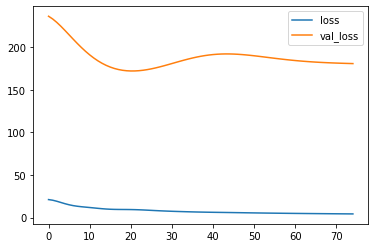

--------------------------------------- Current Engine : 37  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 73ms/step - loss: 367.9089 - val_loss: 250.7696
Epoch 2/75
1/1 [==============================] - 0s 35ms/step - loss: 311.1446 - val_loss: 238.3878
Epoch 3/75
1/1 [==============================] - 0s 51ms/step - loss: 223.3842 - val_loss: 222.7437
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 137.8824 - val_loss: 205.7493
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 91.2882 - val_loss: 188.8769
Epoch 6/75
1/1 [==============================] - 0s 40ms/step - loss: 86.4154 - val_loss: 173.1075
Epoch 7/75
1/1 [==============================] - 0s 65ms/step - loss: 95.6014 - val_loss: 158.9762
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 106.6346 - val_loss: 146.6794
Epoch 9/75
1/1 [==============================] - 0s 52ms/step - loss: 111.1497 - val_loss: 13

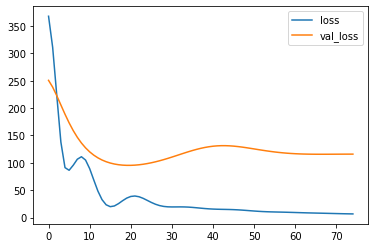

--------------------------------------- Current Engine : 38  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 55ms/step - loss: 970.3374 - val_loss: 85.9308
Epoch 2/75
1/1 [==============================] - 0s 34ms/step - loss: 884.6622 - val_loss: 90.4559
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 739.0297 - val_loss: 97.2520
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 564.7675 - val_loss: 106.4581
Epoch 5/75
1/1 [==============================] - 0s 39ms/step - loss: 392.5270 - val_loss: 118.2400
Epoch 6/75
1/1 [==============================] - 0s 36ms/step - loss: 247.5971 - val_loss: 132.7480
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 144.0105 - val_loss: 150.0770
Epoch 8/75
1/1 [==============================] - 0s 34ms/step - loss: 83.7782 - val_loss: 170.2229
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 61.5743 - val_loss: 193.

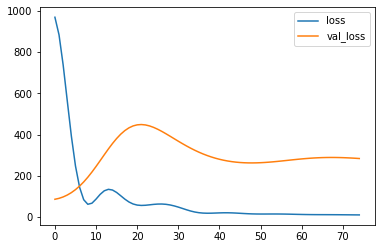

--------------------------------------- Current Engine : 39  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 70ms/step - loss: 3109.6428 - val_loss: 1090.7706
Epoch 2/75
1/1 [==============================] - 0s 31ms/step - loss: 2709.3247 - val_loss: 979.3626
Epoch 3/75
1/1 [==============================] - 0s 35ms/step - loss: 2125.9070 - val_loss: 848.1765
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 1537.7998 - val_loss: 715.9332
Epoch 5/75
1/1 [==============================] - 0s 31ms/step - loss: 1053.5945 - val_loss: 594.5895
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 687.6104 - val_loss: 489.7572
Epoch 7/75
1/1 [==============================] - 0s 33ms/step - loss: 423.4635 - val_loss: 402.9347
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 245.4115 - val_loss: 332.9047
Epoch 9/75
1/1 [==============================] - 0s 32ms/step - loss: 128.6524 - val

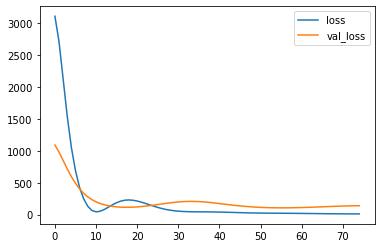

--------------------------------------- Current Engine : 40  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 89ms/step - loss: 2797.1560 - val_loss: 86.9677
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 2689.7129 - val_loss: 99.6721
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 2498.6370 - val_loss: 120.6175
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 2246.6741 - val_loss: 152.7588
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 1957.9801 - val_loss: 200.0483
Epoch 6/75
1/1 [==============================] - 0s 40ms/step - loss: 1658.8931 - val_loss: 267.0680
Epoch 7/75
1/1 [==============================] - 0s 38ms/step - loss: 1376.6052 - val_loss: 358.4322
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 1130.6924 - val_loss: 478.3098
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 931.5345 - val

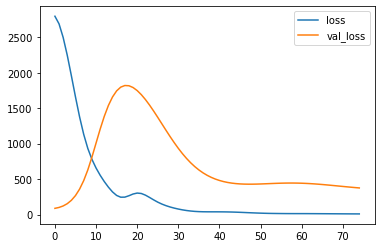

--------------------------------------- Current Engine : 41  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 70ms/step - loss: 570.3687 - val_loss: 398.0230
Epoch 2/75
1/1 [==============================] - 0s 36ms/step - loss: 437.8557 - val_loss: 387.6964
Epoch 3/75
1/1 [==============================] - 0s 34ms/step - loss: 210.2427 - val_loss: 375.2096
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 126.4593 - val_loss: 360.8874
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 148.2213 - val_loss: 345.3753
Epoch 6/75
1/1 [==============================] - 0s 37ms/step - loss: 126.9915 - val_loss: 329.3277
Epoch 7/75
1/1 [==============================] - 0s 40ms/step - loss: 81.7801 - val_loss: 313.3126
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 68.9229 - val_loss: 297.7440
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 62.3162 - val_loss: 28

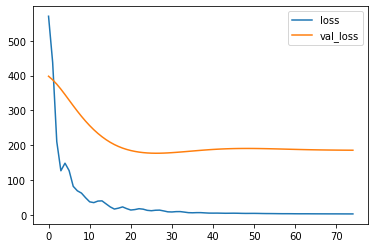

--------------------------------------- Current Engine : 42  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 87ms/step - loss: 483.0933 - val_loss: 245.4606
Epoch 2/75
1/1 [==============================] - 0s 58ms/step - loss: 234.6783 - val_loss: 241.3524
Epoch 3/75
1/1 [==============================] - 0s 50ms/step - loss: 134.8777 - val_loss: 235.8687
Epoch 4/75
1/1 [==============================] - 0s 39ms/step - loss: 131.9219 - val_loss: 229.4602
Epoch 5/75
1/1 [==============================] - 0s 39ms/step - loss: 154.6622 - val_loss: 222.5086
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 164.1658 - val_loss: 215.3154
Epoch 7/75
1/1 [==============================] - 0s 59ms/step - loss: 146.3226 - val_loss: 208.1065
Epoch 8/75
1/1 [==============================] - 0s 50ms/step - loss: 110.6506 - val_loss: 201.0539
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 76.2093 - val_loss: 

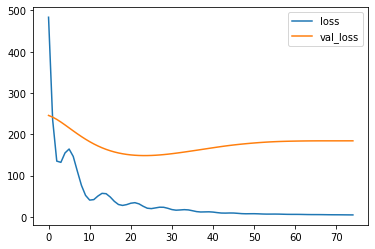

--------------------------------------- Current Engine : 43  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 71ms/step - loss: 200.2179 - val_loss: 215.7523
Epoch 2/75
1/1 [==============================] - 0s 54ms/step - loss: 158.1501 - val_loss: 212.8013
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 124.5558 - val_loss: 208.7771
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 121.0769 - val_loss: 203.9160
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 121.6561 - val_loss: 198.4470
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 107.4862 - val_loss: 192.5727
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 77.9085 - val_loss: 186.5103
Epoch 8/75
1/1 [==============================] - 0s 41ms/step - loss: 51.5730 - val_loss: 180.4647
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - loss: 41.0201 - val_loss: 17

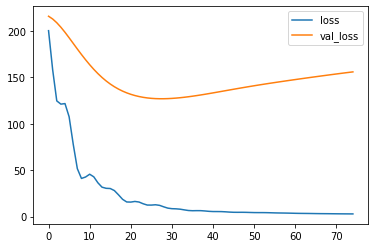

--------------------------------------- Current Engine : 44  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 70ms/step - loss: 20.4613 - val_loss: 153.6052
Epoch 2/75
1/1 [==============================] - 0s 58ms/step - loss: 18.9499 - val_loss: 155.0038
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 16.8213 - val_loss: 156.7875
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 14.7437 - val_loss: 158.9027
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 12.7959 - val_loss: 161.2945
Epoch 6/75
1/1 [==============================] - 0s 36ms/step - loss: 10.8907 - val_loss: 163.9072
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 9.2206 - val_loss: 166.6857
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 8.1007 - val_loss: 169.5761
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 7.5390 - val_loss: 172.5280
Ep

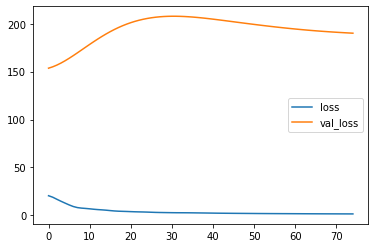

--------------------------------------- Current Engine : 45  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 85ms/step - loss: 965.2070 - val_loss: 255.3006
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 393.1669 - val_loss: 252.5178
Epoch 3/75
1/1 [==============================] - 0s 35ms/step - loss: 146.3926 - val_loss: 248.4496
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 207.7629 - val_loss: 243.6375
Epoch 5/75
1/1 [==============================] - 0s 33ms/step - loss: 288.0123 - val_loss: 238.4202
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 210.2257 - val_loss: 232.8498
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 91.8689 - val_loss: 226.9501
Epoch 8/75
1/1 [==============================] - 0s 41ms/step - loss: 49.8823 - val_loss: 220.8374
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - loss: 45.2009 - val_loss: 21

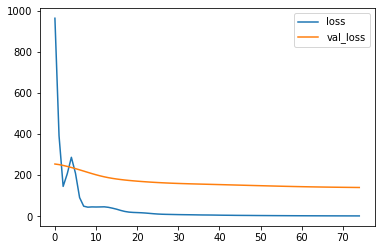

--------------------------------------- Current Engine : 46  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 76ms/step - loss: 4007.8770 - val_loss: 96.6987
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 3198.0054 - val_loss: 97.8737
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 2233.7688 - val_loss: 99.8094
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 1418.3445 - val_loss: 102.6460
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 866.4449 - val_loss: 106.5120
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 577.8768 - val_loss: 111.5138
Epoch 7/75
1/1 [==============================] - 0s 48ms/step - loss: 549.3828 - val_loss: 117.6970
Epoch 8/75
1/1 [==============================] - 0s 40ms/step - loss: 657.7974 - val_loss: 125.0311
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 721.5024 - val_loss

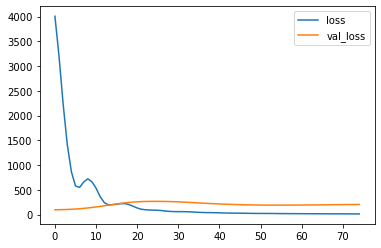

--------------------------------------- Current Engine : 47  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 82ms/step - loss: 717.3203 - val_loss: 234.3196
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 428.8276 - val_loss: 233.8132
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 138.6182 - val_loss: 232.7749
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 63.9806 - val_loss: 231.0062
Epoch 5/75
1/1 [==============================] - 0s 55ms/step - loss: 94.9415 - val_loss: 228.5617
Epoch 6/75
1/1 [==============================] - 0s 56ms/step - loss: 136.0125 - val_loss: 225.5463
Epoch 7/75
1/1 [==============================] - 0s 55ms/step - loss: 141.1412 - val_loss: 222.1384
Epoch 8/75
1/1 [==============================] - 0s 64ms/step - loss: 108.0342 - val_loss: 218.5855
Epoch 9/75
1/1 [==============================] - 0s 59ms/step - loss: 75.4011 - val_loss: 21

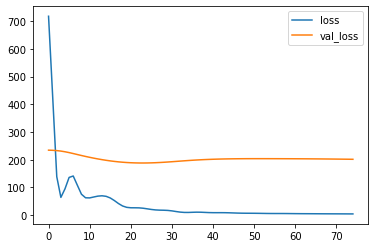

--------------------------------------- Current Engine : 48  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 86ms/step - loss: 241.8584 - val_loss: 224.0580
Epoch 2/75
1/1 [==============================] - 0s 70ms/step - loss: 165.5784 - val_loss: 222.7208
Epoch 3/75
1/1 [==============================] - 0s 58ms/step - loss: 73.4906 - val_loss: 220.8691
Epoch 4/75
1/1 [==============================] - 0s 72ms/step - loss: 32.5496 - val_loss: 218.5411
Epoch 5/75
1/1 [==============================] - 0s 52ms/step - loss: 54.7007 - val_loss: 215.7320
Epoch 6/75
1/1 [==============================] - 0s 55ms/step - loss: 93.9407 - val_loss: 212.4715
Epoch 7/75
1/1 [==============================] - 0s 54ms/step - loss: 98.0272 - val_loss: 208.8434
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 82.1785 - val_loss: 204.9694
Epoch 9/75
1/1 [==============================] - 0s 51ms/step - loss: 64.2864 - val_loss: 200.97

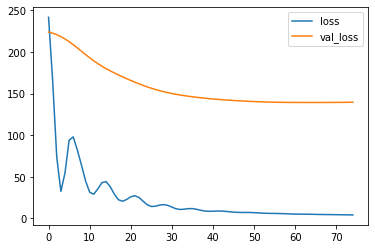

--------------------------------------- Current Engine : 49  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 77ms/step - loss: 347.9295 - val_loss: 155.8717
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 258.9834 - val_loss: 160.9231
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 177.6599 - val_loss: 168.4811
Epoch 4/75
1/1 [==============================] - 0s 54ms/step - loss: 163.5354 - val_loss: 178.6584
Epoch 5/75
1/1 [==============================] - 0s 35ms/step - loss: 157.2094 - val_loss: 191.5253
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 131.1882 - val_loss: 207.1009
Epoch 7/75
1/1 [==============================] - 0s 42ms/step - loss: 93.6788 - val_loss: 225.3376
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 62.2438 - val_loss: 246.1064
Epoch 9/75
1/1 [==============================] - 0s 34ms/step - loss: 44.5733 - val_loss: 26

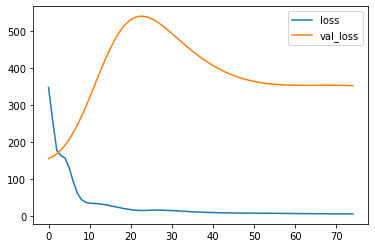

--------------------------------------- Current Engine : 50  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 74ms/step - loss: 81.3292 - val_loss: 305.0929
Epoch 2/75
1/1 [==============================] - 0s 36ms/step - loss: 67.6936 - val_loss: 306.0906
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 50.7973 - val_loss: 307.6473
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 38.0902 - val_loss: 309.6412
Epoch 5/75
1/1 [==============================] - 0s 35ms/step - loss: 31.0964 - val_loss: 311.9470
Epoch 6/75
1/1 [==============================] - 0s 51ms/step - loss: 27.7511 - val_loss: 314.4401
Epoch 7/75
1/1 [==============================] - 0s 36ms/step - loss: 25.5525 - val_loss: 316.9987
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 23.0614 - val_loss: 319.5045
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 19.9386 - val_loss: 321.8458

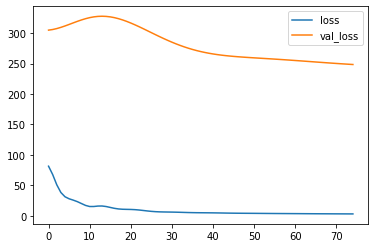

--------------------------------------- Current Engine : 51  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 87ms/step - loss: 194.1040 - val_loss: 296.9050
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 169.5859 - val_loss: 287.6432
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 131.3436 - val_loss: 275.7410
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 92.3511 - val_loss: 262.4158
Epoch 5/75
1/1 [==============================] - 0s 35ms/step - loss: 63.3440 - val_loss: 248.7284
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 47.6351 - val_loss: 235.5067
Epoch 7/75
1/1 [==============================] - 0s 37ms/step - loss: 43.0571 - val_loss: 223.3402
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 43.2341 - val_loss: 212.6048
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 42.7161 - val_loss: 203.5

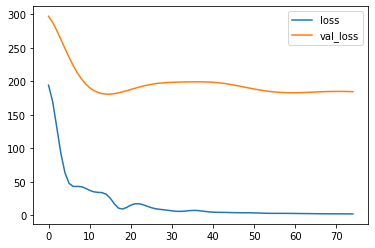

--------------------------------------- Current Engine : 52  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 77ms/step - loss: 50.2832 - val_loss: 174.1315
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 42.2565 - val_loss: 176.8351
Epoch 3/75
1/1 [==============================] - 0s 50ms/step - loss: 31.2066 - val_loss: 180.7530
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 22.4354 - val_loss: 185.7679
Epoch 5/75
1/1 [==============================] - 0s 35ms/step - loss: 18.7965 - val_loss: 191.7619
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 19.6482 - val_loss: 198.6115
Epoch 7/75
1/1 [==============================] - 0s 40ms/step - loss: 21.7239 - val_loss: 206.1821
Epoch 8/75
1/1 [==============================] - 0s 34ms/step - loss: 21.8183 - val_loss: 214.3260
Epoch 9/75
1/1 [==============================] - 0s 41ms/step - loss: 18.8412 - val_loss: 222.8807

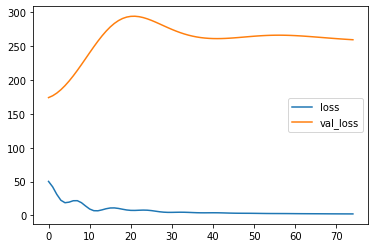

--------------------------------------- Current Engine : 53  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 78ms/step - loss: 39.1878 - val_loss: 277.8008
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 29.9516 - val_loss: 276.6265
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 19.5604 - val_loss: 275.0957
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 14.5172 - val_loss: 273.2293
Epoch 5/75
1/1 [==============================] - 0s 39ms/step - loss: 14.5182 - val_loss: 271.0560
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 16.0214 - val_loss: 268.6116
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 16.5467 - val_loss: 265.9322
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 15.3889 - val_loss: 263.0507
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 12.9538 - val_loss: 259.9980

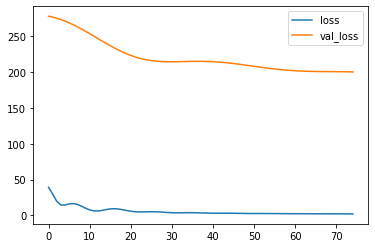

--------------------------------------- Current Engine : 54  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 800.6890 - val_loss: 143.9865
Epoch 2/75
1/1 [==============================] - 0s 36ms/step - loss: 600.8109 - val_loss: 146.9293
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 342.9069 - val_loss: 151.2209
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 158.7775 - val_loss: 156.7201
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 108.4255 - val_loss: 163.2250
Epoch 6/75
1/1 [==============================] - 0s 37ms/step - loss: 165.2494 - val_loss: 170.4723
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 256.4722 - val_loss: 178.1646
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 313.6270 - val_loss: 186.0112
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 307.7622 - val_loss:

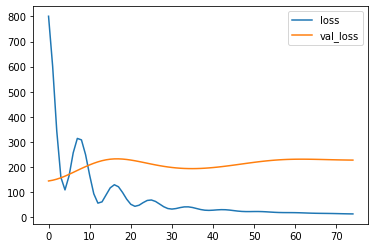

--------------------------------------- Current Engine : 55  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 785.7048 - val_loss: 346.6024
Epoch 2/75
1/1 [==============================] - 0s 50ms/step - loss: 535.4445 - val_loss: 335.9323
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 300.4906 - val_loss: 321.8830
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 178.2768 - val_loss: 305.6161
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 117.2360 - val_loss: 288.3179
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 89.8404 - val_loss: 271.0121
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 81.4786 - val_loss: 254.4685
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 81.3084 - val_loss: 239.2052
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 79.8473 - val_loss: 225

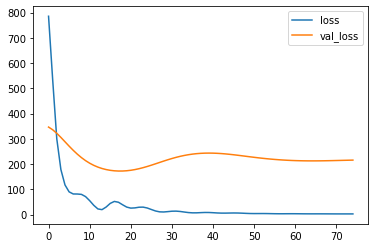

--------------------------------------- Current Engine : 56  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 74ms/step - loss: 6064.8989 - val_loss: 152.9158
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 5526.1348 - val_loss: 170.6161
Epoch 3/75
1/1 [==============================] - 0s 52ms/step - loss: 4611.0186 - val_loss: 202.1609
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 3511.0930 - val_loss: 255.0148
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 2443.5098 - val_loss: 341.3210
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 1588.4951 - val_loss: 478.6303
Epoch 7/75
1/1 [==============================] - 0s 49ms/step - loss: 991.7170 - val_loss: 683.2239
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 599.8845 - val_loss: 956.5204
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 352.6135 - val

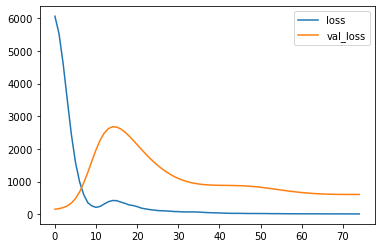

--------------------------------------- Current Engine : 57  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 67ms/step - loss: 20683.8770 - val_loss: 8766.4062
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 18555.5469 - val_loss: 7732.7646
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 15430.4717 - val_loss: 6667.1494
Epoch 4/75
1/1 [==============================] - 0s 31ms/step - loss: 12124.5791 - val_loss: 5655.2812
Epoch 5/75
1/1 [==============================] - 0s 32ms/step - loss: 7865.6069 - val_loss: 4739.7993
Epoch 6/75
1/1 [==============================] - 0s 33ms/step - loss: 3809.3071 - val_loss: 3918.4966
Epoch 7/75
1/1 [==============================] - 0s 34ms/step - loss: 1921.3618 - val_loss: 3182.0581
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 1118.3641 - val_loss: 2543.3142
Epoch 9/75
1/1 [==============================] - 0s 33ms/step - loss: 

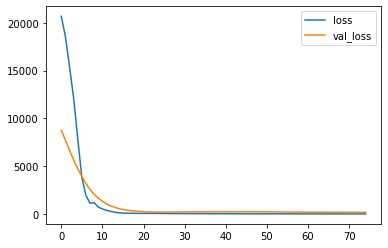

--------------------------------------- Current Engine : 58  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 64ms/step - loss: 75.3553 - val_loss: 166.3370
Epoch 2/75
1/1 [==============================] - 0s 34ms/step - loss: 39.9259 - val_loss: 167.9698
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 38.9587 - val_loss: 170.3910
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 46.9443 - val_loss: 173.4613
Epoch 5/75
1/1 [==============================] - 0s 33ms/step - loss: 51.3135 - val_loss: 177.2761
Epoch 6/75
1/1 [==============================] - 0s 33ms/step - loss: 51.7457 - val_loss: 182.1104
Epoch 7/75
1/1 [==============================] - 0s 31ms/step - loss: 47.7922 - val_loss: 187.8578
Epoch 8/75
1/1 [==============================] - 0s 33ms/step - loss: 39.8716 - val_loss: 193.6222
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 29.5389 - val_loss: 198.4478

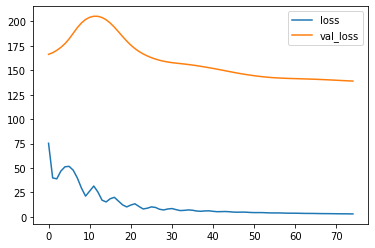

--------------------------------------- Current Engine : 59  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 68ms/step - loss: 2867.0840 - val_loss: 96.3677
Epoch 2/75
1/1 [==============================] - 0s 50ms/step - loss: 2223.2561 - val_loss: 94.3718
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 1619.8666 - val_loss: 93.2081
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 1177.6473 - val_loss: 92.2351
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 837.2480 - val_loss: 91.6037
Epoch 6/75
1/1 [==============================] - 0s 31ms/step - loss: 697.8340 - val_loss: 91.3497
Epoch 7/75
1/1 [==============================] - 0s 31ms/step - loss: 588.5109 - val_loss: 91.9715
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 520.2237 - val_loss: 93.4031
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 344.1578 - val_loss: 95.

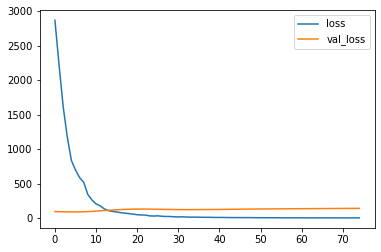

--------------------------------------- Current Engine : 60  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 70ms/step - loss: 482.9935 - val_loss: 254.7827
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 283.7117 - val_loss: 253.0713
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 141.9520 - val_loss: 254.9825
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 99.4225 - val_loss: 258.6172
Epoch 5/75
1/1 [==============================] - 0s 47ms/step - loss: 125.3222 - val_loss: 257.4814
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 171.0918 - val_loss: 248.3383
Epoch 7/75
1/1 [==============================] - 0s 36ms/step - loss: 112.1687 - val_loss: 236.9910
Epoch 8/75
1/1 [==============================] - 0s 34ms/step - loss: 60.0508 - val_loss: 225.1647
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 42.2989 - val_loss: 21

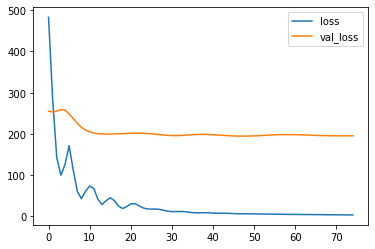

--------------------------------------- Current Engine : 61  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 83ms/step - loss: 2819.3042 - val_loss: 240.5953
Epoch 2/75
1/1 [==============================] - 0s 35ms/step - loss: 965.6337 - val_loss: 224.9431
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 203.8925 - val_loss: 206.4549
Epoch 4/75
1/1 [==============================] - 0s 50ms/step - loss: 289.2067 - val_loss: 187.7329
Epoch 5/75
1/1 [==============================] - 0s 34ms/step - loss: 324.2267 - val_loss: 170.3422
Epoch 6/75
1/1 [==============================] - 0s 36ms/step - loss: 220.7675 - val_loss: 155.0601
Epoch 7/75
1/1 [==============================] - 0s 34ms/step - loss: 126.8256 - val_loss: 142.2430
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 78.5402 - val_loss: 131.9642
Epoch 9/75
1/1 [==============================] - 0s 34ms/step - loss: 44.2721 - val_loss: 

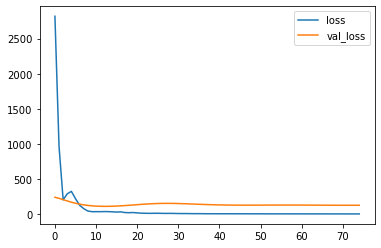

--------------------------------------- Current Engine : 62  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 73ms/step - loss: 4050.6948 - val_loss: 151.1723
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 3576.0613 - val_loss: 199.3357
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 2872.8450 - val_loss: 320.6079
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 2208.3105 - val_loss: 528.7271
Epoch 5/75
1/1 [==============================] - 0s 34ms/step - loss: 1676.2404 - val_loss: 809.6253
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 1280.2236 - val_loss: 1112.7163
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 993.7492 - val_loss: 1448.1429
Epoch 8/75
1/1 [==============================] - 0s 32ms/step - loss: 796.1571 - val_loss: 1781.4531
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 677.0449 - 

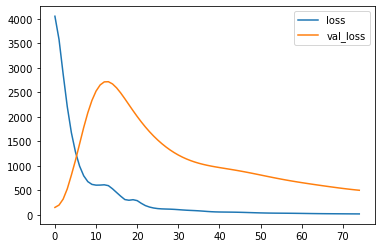

--------------------------------------- Current Engine : 63  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 55ms/step - loss: 813.8156 - val_loss: 633.9239
Epoch 2/75
1/1 [==============================] - 0s 37ms/step - loss: 718.8964 - val_loss: 609.3046
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 559.0883 - val_loss: 579.1595
Epoch 4/75
1/1 [==============================] - 0s 50ms/step - loss: 372.4283 - val_loss: 547.9937
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 213.2241 - val_loss: 520.5684
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 142.4397 - val_loss: 497.9414
Epoch 7/75
1/1 [==============================] - 0s 37ms/step - loss: 134.3696 - val_loss: 478.4770
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 138.2611 - val_loss: 460.9713
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 145.1743 - val_loss:

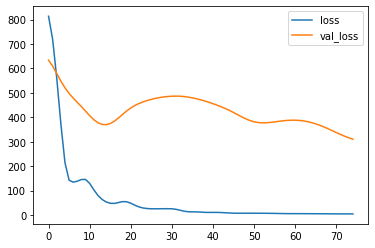

--------------------------------------- Current Engine : 64  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 85ms/step - loss: 5841.1548 - val_loss: 233.4170
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 4850.6772 - val_loss: 245.8551
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 3896.7024 - val_loss: 264.3629
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 2960.5347 - val_loss: 289.7121
Epoch 5/75
1/1 [==============================] - 0s 39ms/step - loss: 2135.2798 - val_loss: 322.7502
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 1596.2805 - val_loss: 364.6076
Epoch 7/75
1/1 [==============================] - 0s 41ms/step - loss: 1294.6362 - val_loss: 416.2071
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 1115.6221 - val_loss: 478.2017
Epoch 9/75
1/1 [==============================] - 0s 38ms/step - loss: 1052.0254 - 

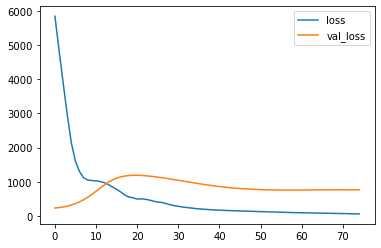

--------------------------------------- Current Engine : 65  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 68ms/step - loss: 17621.4785 - val_loss: 2813.7739
Epoch 2/75
1/1 [==============================] - 0s 36ms/step - loss: 14262.2725 - val_loss: 2651.1570
Epoch 3/75
1/1 [==============================] - 0s 34ms/step - loss: 10144.5137 - val_loss: 2496.7417
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 6960.0420 - val_loss: 2349.5737
Epoch 5/75
1/1 [==============================] - 0s 38ms/step - loss: 4916.2778 - val_loss: 2208.2026
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 3271.7832 - val_loss: 2074.4136
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 2110.8098 - val_loss: 1949.6855
Epoch 8/75
1/1 [==============================] - 0s 32ms/step - loss: 1447.8440 - val_loss: 1834.7946
Epoch 9/75
1/1 [==============================] - 0s 36ms/step - loss: 1

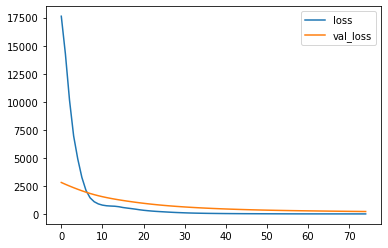

--------------------------------------- Current Engine : 66  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 69ms/step - loss: 6782.5952 - val_loss: 188.9639
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 6572.8438 - val_loss: 219.7516
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 6232.7646 - val_loss: 265.0233
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 5807.9639 - val_loss: 324.6295
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 5332.3140 - val_loss: 397.3772
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 4831.3159 - val_loss: 481.7785
Epoch 7/75
1/1 [==============================] - 0s 34ms/step - loss: 4324.9565 - val_loss: 576.7797
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 3830.4072 - val_loss: 681.8677
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 3362.3379 - 

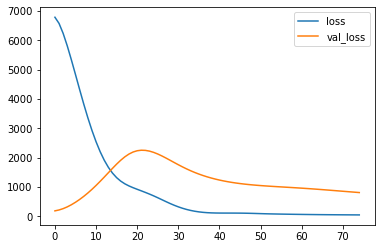

--------------------------------------- Current Engine : 67  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 75ms/step - loss: 8156.3179 - val_loss: 507.3055
Epoch 2/75
1/1 [==============================] - 0s 50ms/step - loss: 7875.6431 - val_loss: 508.8388
Epoch 3/75
1/1 [==============================] - 0s 51ms/step - loss: 7370.9492 - val_loss: 513.7187
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 6673.1865 - val_loss: 521.4487
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 5830.3843 - val_loss: 531.5804
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 4982.4404 - val_loss: 543.6729
Epoch 7/75
1/1 [==============================] - 0s 37ms/step - loss: 4236.9346 - val_loss: 557.2890
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 3606.8594 - val_loss: 572.0240
Epoch 9/75
1/1 [==============================] - 0s 39ms/step - loss: 3112.5637 - 

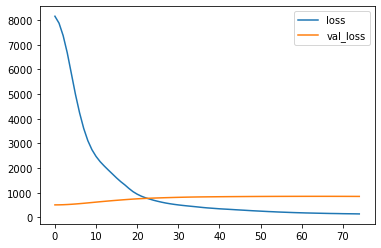

--------------------------------------- Current Engine : 68  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 67ms/step - loss: 7165.4976 - val_loss: 1376.2885
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 4711.6113 - val_loss: 1344.4656
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 2573.7749 - val_loss: 1308.0771
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 1073.1875 - val_loss: 1268.6849
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 503.9153 - val_loss: 1228.4802
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 393.7385 - val_loss: 1194.6720
Epoch 7/75
1/1 [==============================] - 0s 36ms/step - loss: 316.5696 - val_loss: 1169.0988
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 173.2367 - val_loss: 1148.1901
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 122.7479

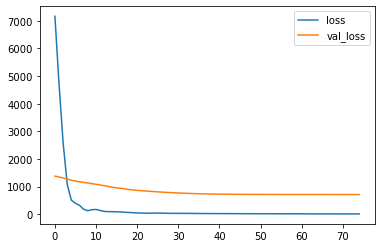

--------------------------------------- Current Engine : 69  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 87ms/step - loss: 8231.0850 - val_loss: 548.6532
Epoch 2/75
1/1 [==============================] - 0s 48ms/step - loss: 6982.0020 - val_loss: 556.6132
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 5982.6289 - val_loss: 567.7410
Epoch 4/75
1/1 [==============================] - 0s 49ms/step - loss: 5544.3594 - val_loss: 581.4664
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 5379.4297 - val_loss: 597.2431
Epoch 6/75
1/1 [==============================] - 0s 55ms/step - loss: 5268.8647 - val_loss: 614.7734
Epoch 7/75
1/1 [==============================] - 0s 42ms/step - loss: 5117.2744 - val_loss: 633.5814
Epoch 8/75
1/1 [==============================] - 0s 57ms/step - loss: 4932.2402 - val_loss: 653.2344
Epoch 9/75
1/1 [==============================] - 0s 52ms/step - loss: 4718.9238 - 

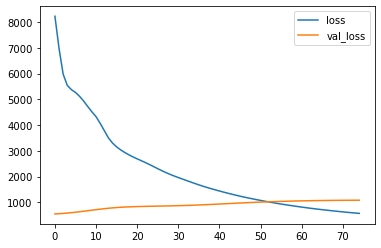

--------------------------------------- Current Engine : 70  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 101ms/step - loss: 21761.5977 - val_loss: 2165.9053
Epoch 2/75
1/1 [==============================] - 0s 58ms/step - loss: 18843.3359 - val_loss: 2086.2917
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 14345.4121 - val_loss: 1991.1548
Epoch 4/75
1/1 [==============================] - 0s 58ms/step - loss: 8222.5684 - val_loss: 1889.0072
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 4832.9077 - val_loss: 1781.8596
Epoch 6/75
1/1 [==============================] - 0s 48ms/step - loss: 3340.7554 - val_loss: 1674.2001
Epoch 7/75
1/1 [==============================] - 0s 42ms/step - loss: 2427.1372 - val_loss: 1567.2478
Epoch 8/75
1/1 [==============================] - 0s 35ms/step - loss: 1252.9567 - val_loss: 1444.1656
Epoch 9/75
1/1 [==============================] - 0s 34ms/step - loss: 

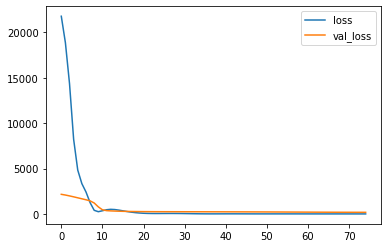

--------------------------------------- Current Engine : 71  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 71ms/step - loss: 2247.4985 - val_loss: 123.8398
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 2092.3423 - val_loss: 127.8362
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 1847.5979 - val_loss: 133.7538
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 1570.0618 - val_loss: 141.5733
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 1296.3824 - val_loss: 151.2475
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 1027.4801 - val_loss: 162.6712
Epoch 7/75
1/1 [==============================] - 0s 40ms/step - loss: 710.9565 - val_loss: 175.7054
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 455.7399 - val_loss: 189.9408
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 308.4691 - val

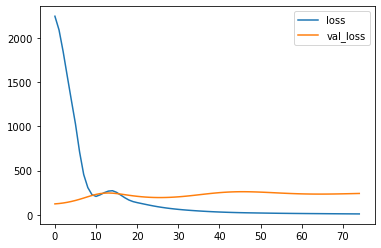

--------------------------------------- Current Engine : 72  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 77ms/step - loss: 797.4659 - val_loss: 527.6667
Epoch 2/75
1/1 [==============================] - 0s 51ms/step - loss: 745.0603 - val_loss: 512.6437
Epoch 3/75
1/1 [==============================] - 0s 35ms/step - loss: 647.2912 - val_loss: 493.3461
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 505.9563 - val_loss: 472.8856
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 386.3227 - val_loss: 450.9320
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 316.9376 - val_loss: 428.5898
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 257.5332 - val_loss: 406.8137
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 206.9465 - val_loss: 386.3204
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 164.5718 - val_loss:

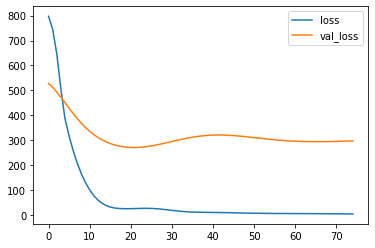

--------------------------------------- Current Engine : 73  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 76ms/step - loss: 1752.0500 - val_loss: 251.5659
Epoch 2/75
1/1 [==============================] - 0s 45ms/step - loss: 1544.6036 - val_loss: 282.7461
Epoch 3/75
1/1 [==============================] - 0s 53ms/step - loss: 1199.8617 - val_loss: 328.4003
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 809.6294 - val_loss: 389.3493
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 489.9755 - val_loss: 464.2739
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 283.1788 - val_loss: 550.1328
Epoch 7/75
1/1 [==============================] - 0s 53ms/step - loss: 169.8332 - val_loss: 644.6893
Epoch 8/75
1/1 [==============================] - 0s 47ms/step - loss: 118.7234 - val_loss: 746.0864
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 105.0034 - val_lo

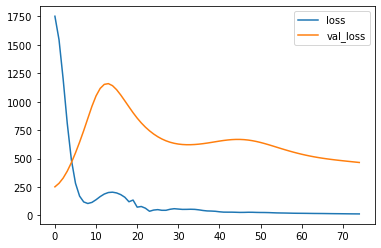

--------------------------------------- Current Engine : 74  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 69ms/step - loss: 943.6586 - val_loss: 675.8746
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 878.7750 - val_loss: 661.3702
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 776.3822 - val_loss: 643.0117
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 659.2764 - val_loss: 621.9885
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 547.3834 - val_loss: 599.3160
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 460.1368 - val_loss: 575.8146
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 408.5110 - val_loss: 552.1094
Epoch 8/75
1/1 [==============================] - 0s 48ms/step - loss: 377.2003 - val_loss: 528.7294
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 339.0562 - val_loss:

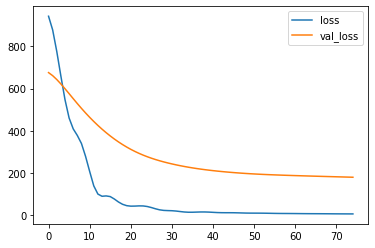

--------------------------------------- Current Engine : 75  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 61ms/step - loss: 287.4196 - val_loss: 141.7642
Epoch 2/75
1/1 [==============================] - 0s 48ms/step - loss: 262.4746 - val_loss: 144.2333
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 227.0878 - val_loss: 147.8878
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 191.3169 - val_loss: 152.6118
Epoch 5/75
1/1 [==============================] - 0s 38ms/step - loss: 150.4621 - val_loss: 158.3094
Epoch 6/75
1/1 [==============================] - 0s 36ms/step - loss: 105.4137 - val_loss: 164.9278
Epoch 7/75
1/1 [==============================] - 0s 37ms/step - loss: 71.9173 - val_loss: 172.4805
Epoch 8/75
1/1 [==============================] - 0s 35ms/step - loss: 45.8525 - val_loss: 181.2751
Epoch 9/75
1/1 [==============================] - 0s 36ms/step - loss: 35.2621 - val_loss: 19

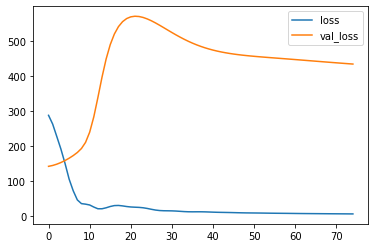

--------------------------------------- Current Engine : 76  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 176.8463 - val_loss: 175.6527
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 158.4026 - val_loss: 177.6001
Epoch 3/75
1/1 [==============================] - 0s 40ms/step - loss: 132.7748 - val_loss: 180.5700
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 108.9633 - val_loss: 184.5254
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 88.6563 - val_loss: 189.3996
Epoch 6/75
1/1 [==============================] - 0s 41ms/step - loss: 70.8583 - val_loss: 195.1623
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 54.9467 - val_loss: 202.0906
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 41.6829 - val_loss: 210.9878
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 31.8326 - val_loss: 222.

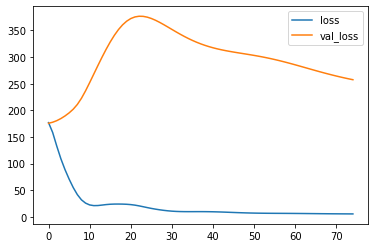

--------------------------------------- Current Engine : 77  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 67ms/step - loss: 3300.1028 - val_loss: 400.8355
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 2448.3528 - val_loss: 391.3867
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 1493.3647 - val_loss: 379.5475
Epoch 4/75
1/1 [==============================] - 0s 45ms/step - loss: 811.3979 - val_loss: 366.1904
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 480.7182 - val_loss: 351.9901
Epoch 6/75
1/1 [==============================] - 0s 37ms/step - loss: 329.6718 - val_loss: 337.4586
Epoch 7/75
1/1 [==============================] - 0s 37ms/step - loss: 278.7981 - val_loss: 322.9694
Epoch 8/75
1/1 [==============================] - 0s 34ms/step - loss: 280.2271 - val_loss: 308.8034
Epoch 9/75
1/1 [==============================] - 0s 36ms/step - loss: 305.7105 - val_lo

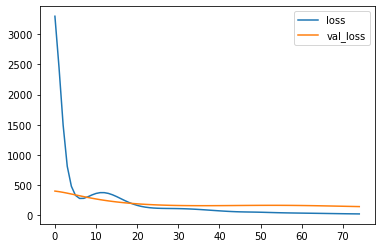

--------------------------------------- Current Engine : 78  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 883.2287 - val_loss: 86.1743
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 657.0693 - val_loss: 86.0916
Epoch 3/75
1/1 [==============================] - 0s 40ms/step - loss: 399.4184 - val_loss: 86.1655
Epoch 4/75
1/1 [==============================] - 0s 39ms/step - loss: 193.3259 - val_loss: 86.3639
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 82.9150 - val_loss: 86.6536
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 120.3740 - val_loss: 86.9668
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 166.4012 - val_loss: 87.2891
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 190.4492 - val_loss: 87.6188
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 194.9584 - val_loss: 87.9465


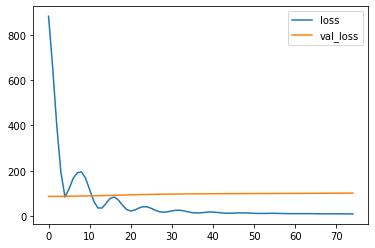

--------------------------------------- Current Engine : 79  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 382.9655 - val_loss: 125.0940
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 286.4571 - val_loss: 124.5839
Epoch 3/75
1/1 [==============================] - 0s 40ms/step - loss: 155.9977 - val_loss: 123.8549
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 62.7745 - val_loss: 122.9840
Epoch 5/75
1/1 [==============================] - 0s 38ms/step - loss: 38.4920 - val_loss: 122.0375
Epoch 6/75
1/1 [==============================] - 0s 36ms/step - loss: 60.1370 - val_loss: 121.0681
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 98.3538 - val_loss: 120.1147
Epoch 8/75
1/1 [==============================] - 0s 35ms/step - loss: 132.3537 - val_loss: 119.2030
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 148.6275 - val_loss: 118

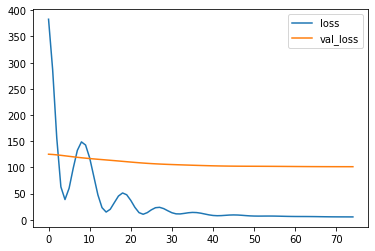

--------------------------------------- Current Engine : 80  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 57ms/step - loss: 1206.3999 - val_loss: 112.8083
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 1094.5969 - val_loss: 118.4103
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 914.9563 - val_loss: 126.3974
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 805.1772 - val_loss: 136.7096
Epoch 5/75
1/1 [==============================] - 0s 53ms/step - loss: 590.2570 - val_loss: 149.4996
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 457.7279 - val_loss: 164.6553
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 352.8331 - val_loss: 181.9859
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 270.9785 - val_loss: 201.2091
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 208.8056 - val_los

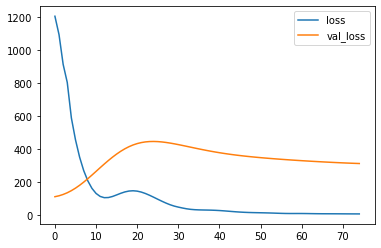

--------------------------------------- Current Engine : 81  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 2556.2371 - val_loss: 367.7427
Epoch 2/75
1/1 [==============================] - 0s 37ms/step - loss: 2211.9668 - val_loss: 375.7291
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 1672.7094 - val_loss: 386.9668
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 1191.9753 - val_loss: 400.7184
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 825.9324 - val_loss: 415.9097
Epoch 6/75
1/1 [==============================] - 0s 41ms/step - loss: 497.4489 - val_loss: 431.4346
Epoch 7/75
1/1 [==============================] - 0s 55ms/step - loss: 270.8004 - val_loss: 446.4552
Epoch 8/75
1/1 [==============================] - 0s 55ms/step - loss: 152.0634 - val_loss: 460.3409
Epoch 9/75
1/1 [==============================] - 0s 48ms/step - loss: 108.8468 - val_l

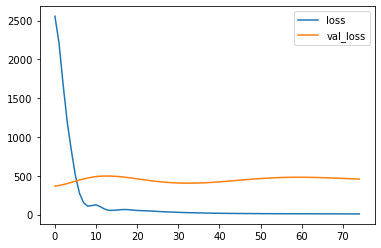

--------------------------------------- Current Engine : 82  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 6306.7788 - val_loss: 453.2786
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 3816.0598 - val_loss: 443.2272
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 2643.1860 - val_loss: 429.9770
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 1964.2504 - val_loss: 414.7119
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 1380.3936 - val_loss: 398.6220
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 923.9745 - val_loss: 382.5310
Epoch 7/75
1/1 [==============================] - 0s 41ms/step - loss: 636.5043 - val_loss: 366.9110
Epoch 8/75
1/1 [==============================] - 0s 35ms/step - loss: 480.2420 - val_loss: 352.0294
Epoch 9/75
1/1 [==============================] - 0s 52ms/step - loss: 431.7810 - val_

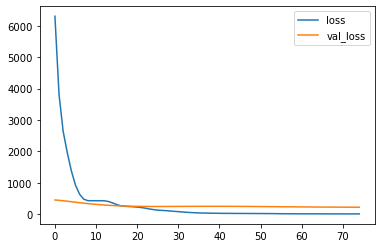

--------------------------------------- Current Engine : 83  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 77ms/step - loss: 2253.4011 - val_loss: 295.4742
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 1707.2783 - val_loss: 294.8588
Epoch 3/75
1/1 [==============================] - 0s 53ms/step - loss: 1133.3573 - val_loss: 294.4716
Epoch 4/75
1/1 [==============================] - 0s 49ms/step - loss: 826.6268 - val_loss: 294.3328
Epoch 5/75
1/1 [==============================] - 0s 41ms/step - loss: 654.3604 - val_loss: 294.3634
Epoch 6/75
1/1 [==============================] - 0s 50ms/step - loss: 553.0144 - val_loss: 294.4414
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 503.8251 - val_loss: 294.4434
Epoch 8/75
1/1 [==============================] - 0s 57ms/step - loss: 491.8597 - val_loss: 294.2385
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 501.4227 - val_lo

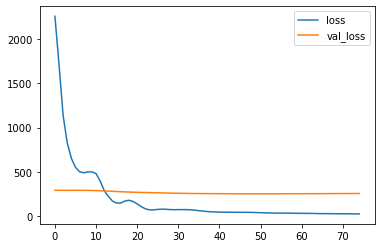

--------------------------------------- Current Engine : 84  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 64ms/step - loss: 2885.6038 - val_loss: 169.9023
Epoch 2/75
1/1 [==============================] - 0s 27ms/step - loss: 2639.3875 - val_loss: 175.7802
Epoch 3/75
1/1 [==============================] - 0s 25ms/step - loss: 2221.0076 - val_loss: 184.2725
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 1745.7355 - val_loss: 195.2960
Epoch 5/75
1/1 [==============================] - 0s 30ms/step - loss: 1290.6361 - val_loss: 208.8086
Epoch 6/75
1/1 [==============================] - 0s 30ms/step - loss: 894.4458 - val_loss: 224.9401
Epoch 7/75
1/1 [==============================] - 0s 29ms/step - loss: 567.0449 - val_loss: 244.4592
Epoch 8/75
1/1 [==============================] - 0s 28ms/step - loss: 329.8393 - val_loss: 268.6676
Epoch 9/75
1/1 [==============================] - 0s 25ms/step - loss: 189.5431 - val_

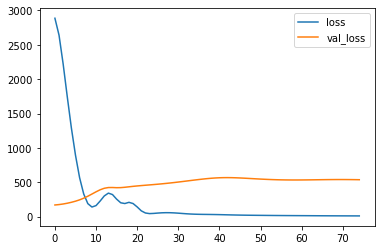

--------------------------------------- Current Engine : 85  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 63ms/step - loss: 7184.6450 - val_loss: 1918.8511
Epoch 2/75
1/1 [==============================] - 0s 59ms/step - loss: 5675.1289 - val_loss: 1807.8214
Epoch 3/75
1/1 [==============================] - 0s 54ms/step - loss: 4094.0376 - val_loss: 1678.0640
Epoch 4/75
1/1 [==============================] - 0s 43ms/step - loss: 2897.2922 - val_loss: 1543.5656
Epoch 5/75
1/1 [==============================] - 0s 68ms/step - loss: 2250.9353 - val_loss: 1414.3589
Epoch 6/75
1/1 [==============================] - 0s 69ms/step - loss: 1821.2739 - val_loss: 1296.3726
Epoch 7/75
1/1 [==============================] - 0s 51ms/step - loss: 1430.2831 - val_loss: 1191.9114
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 1093.6248 - val_loss: 1100.9972
Epoch 9/75
1/1 [==============================] - 0s 65ms/step - loss: 826.

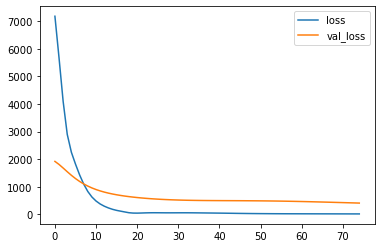

--------------------------------------- Current Engine : 86  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 80ms/step - loss: 5442.1313 - val_loss: 229.1243
Epoch 2/75
1/1 [==============================] - 0s 75ms/step - loss: 4744.8433 - val_loss: 238.2787
Epoch 3/75
1/1 [==============================] - 0s 67ms/step - loss: 3868.0867 - val_loss: 252.3427
Epoch 4/75
1/1 [==============================] - 0s 64ms/step - loss: 3010.9426 - val_loss: 271.2382
Epoch 5/75
1/1 [==============================] - 0s 60ms/step - loss: 2276.3679 - val_loss: 294.9188
Epoch 6/75
1/1 [==============================] - 0s 54ms/step - loss: 1673.3789 - val_loss: 323.2849
Epoch 7/75
1/1 [==============================] - 0s 81ms/step - loss: 1186.1169 - val_loss: 356.1075
Epoch 8/75
1/1 [==============================] - 0s 61ms/step - loss: 855.3621 - val_loss: 393.0252
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 666.9977 - va

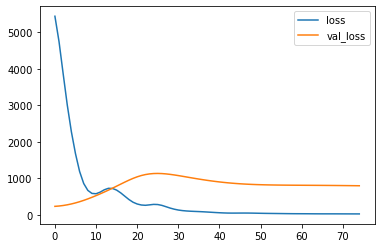

--------------------------------------- Current Engine : 87  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 88ms/step - loss: 4811.8335 - val_loss: 1274.7388
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 4201.9756 - val_loss: 1244.6472
Epoch 3/75
1/1 [==============================] - 0s 47ms/step - loss: 3339.3901 - val_loss: 1206.9332
Epoch 4/75
1/1 [==============================] - 0s 64ms/step - loss: 2485.2615 - val_loss: 1165.2762
Epoch 5/75
1/1 [==============================] - 0s 46ms/step - loss: 1845.6047 - val_loss: 1122.2800
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 1309.1954 - val_loss: 1079.7377
Epoch 7/75
1/1 [==============================] - 0s 50ms/step - loss: 926.0997 - val_loss: 1038.7333
Epoch 8/75
1/1 [==============================] - 0s 65ms/step - loss: 635.0641 - val_loss: 999.8372
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 430.457

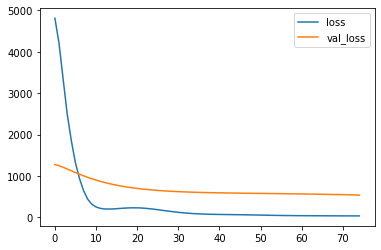

--------------------------------------- Current Engine : 88  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 71ms/step - loss: 257.8004 - val_loss: 453.4142
Epoch 2/75
1/1 [==============================] - 0s 52ms/step - loss: 255.3340 - val_loss: 451.9350
Epoch 3/75
1/1 [==============================] - 0s 40ms/step - loss: 251.6709 - val_loss: 450.7336
Epoch 4/75
1/1 [==============================] - ETA: 0s - loss: 247.026 - 0s 36ms/step - loss: 247.0265 - val_loss: 449.7769
Epoch 5/75
1/1 [==============================] - 0s 39ms/step - loss: 241.6149 - val_loss: 449.0352
Epoch 6/75
1/1 [==============================] - 0s 36ms/step - loss: 235.6405 - val_loss: 448.4805
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 229.2898 - val_loss: 448.0873
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 222.7241 - val_loss: 447.8322
Epoch 9/75
1/1 [==============================] - 0s 38ms/step - 

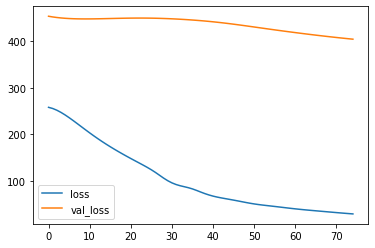

--------------------------------------- Current Engine : 89  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 60ms/step - loss: 248.1783 - val_loss: 385.5001
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 233.7942 - val_loss: 383.6814
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 209.3270 - val_loss: 381.4753
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 179.4538 - val_loss: 378.9568
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 155.1573 - val_loss: 376.1983
Epoch 6/75
1/1 [==============================] - 0s 36ms/step - loss: 132.0320 - val_loss: 373.2646
Epoch 7/75
1/1 [==============================] - 0s 37ms/step - loss: 110.1899 - val_loss: 370.2155
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 91.8296 - val_loss: 367.1057
Epoch 9/75
1/1 [==============================] - 0s 36ms/step - loss: 77.6009 - val_loss: 3

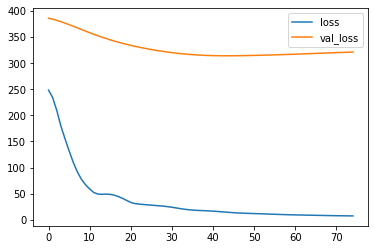

--------------------------------------- Current Engine : 90  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 64ms/step - loss: 2666.7158 - val_loss: 615.8937
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 2432.9519 - val_loss: 602.5063
Epoch 3/75
1/1 [==============================] - 0s 33ms/step - loss: 2032.7145 - val_loss: 584.0680
Epoch 4/75
1/1 [==============================] - 0s 34ms/step - loss: 1500.9036 - val_loss: 562.5787
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 1041.1376 - val_loss: 540.4583
Epoch 6/75
1/1 [==============================] - 0s 34ms/step - loss: 703.2861 - val_loss: 519.7037
Epoch 7/75
1/1 [==============================] - 0s 31ms/step - loss: 439.5787 - val_loss: 501.1081
Epoch 8/75
1/1 [==============================] - 0s 32ms/step - loss: 280.1894 - val_loss: 484.6005
Epoch 9/75
1/1 [==============================] - 0s 31ms/step - loss: 221.6682 - val_

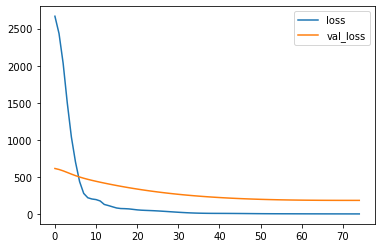

--------------------------------------- Current Engine : 91  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 60ms/step - loss: 950.6868 - val_loss: 203.2678
Epoch 2/75
1/1 [==============================] - 0s 33ms/step - loss: 792.5019 - val_loss: 213.5651
Epoch 3/75
1/1 [==============================] - 0s 33ms/step - loss: 528.7517 - val_loss: 226.7319
Epoch 4/75
1/1 [==============================] - 0s 32ms/step - loss: 268.0069 - val_loss: 246.1038
Epoch 5/75
1/1 [==============================] - 0s 32ms/step - loss: 132.1545 - val_loss: 277.0780
Epoch 6/75
1/1 [==============================] - 0s 35ms/step - loss: 82.4496 - val_loss: 308.9233
Epoch 7/75
1/1 [==============================] - 0s 32ms/step - loss: 69.1106 - val_loss: 330.3346
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 73.2754 - val_loss: 343.3517
Epoch 9/75
1/1 [==============================] - 0s 33ms/step - loss: 81.6620 - val_loss: 353

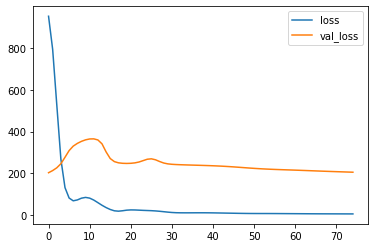

--------------------------------------- Current Engine : 92  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 92ms/step - loss: 19194.1367 - val_loss: 188.0250
Epoch 2/75
1/1 [==============================] - 0s 45ms/step - loss: 18101.8281 - val_loss: 185.8073
Epoch 3/75
1/1 [==============================] - 0s 55ms/step - loss: 16428.4551 - val_loss: 181.5644
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 14587.6592 - val_loss: 170.4694
Epoch 5/75
1/1 [==============================] - 0s 77ms/step - loss: 12794.4775 - val_loss: 195.7050
Epoch 6/75
1/1 [==============================] - 0s 66ms/step - loss: 11078.2520 - val_loss: 208.8143
Epoch 7/75
1/1 [==============================] - 0s 60ms/step - loss: 9257.7119 - val_loss: 224.6122
Epoch 8/75
1/1 [==============================] - 0s 76ms/step - loss: 7312.9233 - val_loss: 246.0442
Epoch 9/75
1/1 [==============================] - 0s 54ms/step - loss: 5579.6

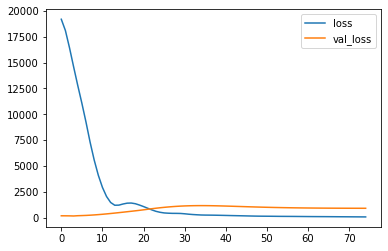

--------------------------------------- Current Engine : 93  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 91ms/step - loss: 22984.5527 - val_loss: 1853.9247
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 21515.2832 - val_loss: 1814.1542
Epoch 3/75
1/1 [==============================] - 0s 50ms/step - loss: 18631.2305 - val_loss: 1763.3036
Epoch 4/75
1/1 [==============================] - 0s 57ms/step - loss: 14631.2480 - val_loss: 1703.2039
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 10368.9688 - val_loss: 1637.3800
Epoch 6/75
1/1 [==============================] - 0s 36ms/step - loss: 7443.5342 - val_loss: 1566.2227
Epoch 7/75
1/1 [==============================] - 0s 37ms/step - loss: 5510.0024 - val_loss: 1492.6260
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 4212.7612 - val_loss: 1419.8334
Epoch 9/75
1/1 [==============================] - 0s 48ms/step - loss:

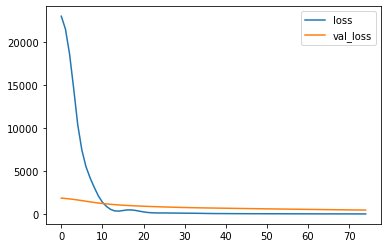

--------------------------------------- Current Engine : 94  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 81ms/step - loss: 4852.2983 - val_loss: 305.2648
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 4688.6016 - val_loss: 314.7531
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 4396.8198 - val_loss: 329.9627
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 4032.0020 - val_loss: 348.4417
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 3597.9082 - val_loss: 371.9763
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 3157.0559 - val_loss: 411.8279
Epoch 7/75
1/1 [==============================] - 0s 36ms/step - loss: 2730.8738 - val_loss: 466.4240
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 2257.6721 - val_loss: 519.0659
Epoch 9/75
1/1 [==============================] - 0s 41ms/step - loss: 1825.9248 - 

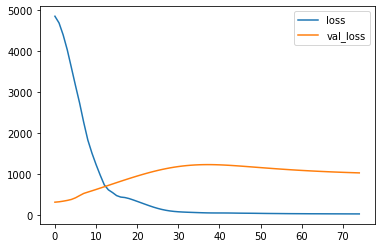

--------------------------------------- Current Engine : 95  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 90ms/step - loss: 4274.3799 - val_loss: 1015.4705
Epoch 2/75
1/1 [==============================] - 0s 41ms/step - loss: 4059.5869 - val_loss: 1016.7910
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 3793.2427 - val_loss: 1019.7754
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 3542.3682 - val_loss: 1023.9705
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 3345.2231 - val_loss: 1029.0105
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 3193.5386 - val_loss: 1034.5793
Epoch 7/75
1/1 [==============================] - 0s 42ms/step - loss: 3065.7744 - val_loss: 1040.3895
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 2946.4536 - val_loss: 1046.2080
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 2822

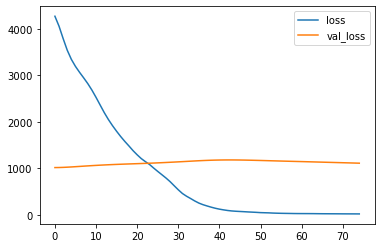

--------------------------------------- Current Engine : 96  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 114ms/step - loss: 5030.3135 - val_loss: 878.2256
Epoch 2/75
1/1 [==============================] - 0s 51ms/step - loss: 3474.2827 - val_loss: 884.5828
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 1910.2917 - val_loss: 893.0659
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 816.4213 - val_loss: 902.5955
Epoch 5/75
1/1 [==============================] - 0s 50ms/step - loss: 399.4041 - val_loss: 912.1810
Epoch 6/75
1/1 [==============================] - 0s 41ms/step - loss: 521.2634 - val_loss: 921.0626
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 839.3123 - val_loss: 928.8011
Epoch 8/75
1/1 [==============================] - ETA: 0s - loss: 1101.16 - 0s 45ms/step - loss: 1101.1687 - val_loss: 935.2217
Epoch 9/75
1/1 [==============================] - 0s 44ms/st

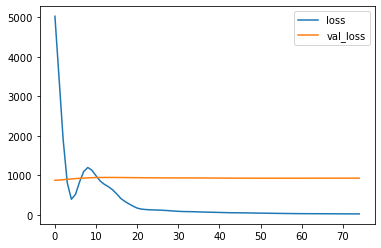

--------------------------------------- Current Engine : 97  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 129ms/step - loss: 15369.0049 - val_loss: 2310.4648
Epoch 2/75
1/1 [==============================] - 0s 59ms/step - loss: 12412.7627 - val_loss: 2120.5403
Epoch 3/75
1/1 [==============================] - 0s 62ms/step - loss: 8866.9678 - val_loss: 1951.5192
Epoch 4/75
1/1 [==============================] - 0s 59ms/step - loss: 5654.2012 - val_loss: 1803.9023
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 3743.1960 - val_loss: 1679.0494
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 2469.3098 - val_loss: 1579.8441
Epoch 7/75
1/1 [==============================] - 0s 50ms/step - loss: 1412.8319 - val_loss: 1497.5101
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 746.7853 - val_loss: 1430.9441
Epoch 9/75
1/1 [==============================] - 0s 39ms/step - loss: 43

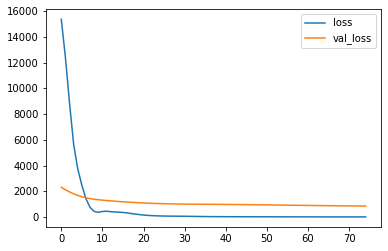

--------------------------------------- Current Engine : 98  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 112ms/step - loss: 1490.6584 - val_loss: 1999.4158
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 1220.7573 - val_loss: 1914.5906
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 858.9520 - val_loss: 1810.4265
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 543.4846 - val_loss: 1700.9768
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 318.6945 - val_loss: 1600.0458
Epoch 6/75
1/1 [==============================] - 0s 41ms/step - loss: 199.2032 - val_loss: 1517.7534
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 165.8710 - val_loss: 1455.4268
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 167.7642 - val_loss: 1408.7623
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 171.9220 

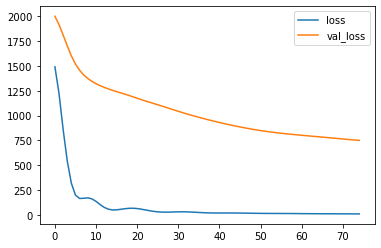

--------------------------------------- Current Engine : 99  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 451.8413 - val_loss: 786.6562
Epoch 2/75
1/1 [==============================] - 0s 36ms/step - loss: 411.4787 - val_loss: 784.4390
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 343.5421 - val_loss: 781.8500
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 266.1151 - val_loss: 778.4406
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 194.5739 - val_loss: 773.8525
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 138.8833 - val_loss: 767.7921
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 102.4875 - val_loss: 759.9084
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 83.6131 - val_loss: 750.0110
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 78.9722 - val_loss: 7

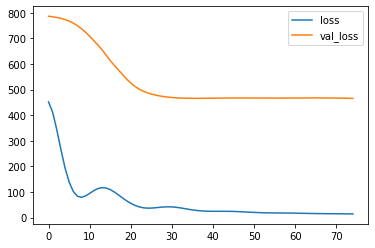

--------------------------------------- Current Engine : 100  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 71ms/step - loss: 1307.3602 - val_loss: 423.9506
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 1179.8844 - val_loss: 435.6203
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 981.6297 - val_loss: 451.2090
Epoch 4/75
1/1 [==============================] - 0s 44ms/step - loss: 765.5363 - val_loss: 469.5943
Epoch 5/75
1/1 [==============================] - 0s 60ms/step - loss: 566.7701 - val_loss: 489.8458
Epoch 6/75
1/1 [==============================] - 0s 45ms/step - loss: 399.6676 - val_loss: 511.2152
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 265.6682 - val_loss: 533.0925
Epoch 8/75
1/1 [==============================] - 0s 40ms/step - loss: 165.5249 - val_loss: 554.9613
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 104.2330 - val_lo

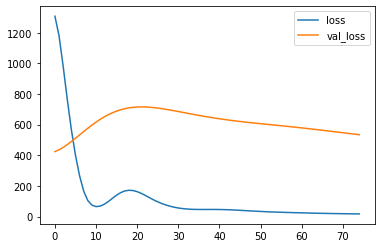

In [89]:
for i in range(len(X_train_new)):
    print("--------------------------------------- Current Engine :",i+1," ---------------------------------------")
    history = model.fit(
    X_train_new[i],
    y_train_new[i],
    batch_size=512,
    epochs=75,
    validation_split=0.15,
    verbose=1)
    # Loss Graph
    plt.plot(history.epoch, history.history['loss'] , label = "loss")
    plt.plot(history.epoch, history.history['val_loss'] , label = "val_loss")
    plt.legend()
    plt.show()

In [91]:
mses=[]
rmses=[]
maes=[]
for i in range(len(X_train_new)):
    
    print("--------------------------------------- Current Engine :",i+1," ---------------------------------------")
    
    y_train_pred = model.predict(X_train_new[i])
    
    mses.append(mean_squared_error(y_train_new[i],y_train_pred))
    rmses.append(math.sqrt(mean_squared_error(y_train_new[i],y_train_pred)))
    maes.append(mean_absolute_error(y_train_new[i],y_train_pred))
    
    print("mean_squared_error >> ", mean_squared_error(y_train_new[i],y_train_pred))
    print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_train_new[i],y_train_pred)))
    print("mean_absolute_error >>",mean_absolute_error(y_train_new[i],y_train_pred))

--------------------------------------- Current Engine : 1  ---------------------------------------
mean_squared_error >>  1853.632112523855
root_mean_squared_error >>  43.05382808210967
mean_absolute_error >> 37.50089330840529
--------------------------------------- Current Engine : 2  ---------------------------------------
mean_squared_error >>  1548.4302510527025
root_mean_squared_error >>  39.350098488475254
mean_absolute_error >> 28.367603029523575
--------------------------------------- Current Engine : 3  ---------------------------------------
mean_squared_error >>  1510.7815583692798
root_mean_squared_error >>  38.8687735639971
mean_absolute_error >> 37.69391557234752
--------------------------------------- Current Engine : 4  ---------------------------------------
mean_squared_error >>  637.9910020617409
root_mean_squared_error >>  25.258483764108664
mean_absolute_error >> 24.319924944923038
--------------------------------------- Current Engine : 5  -----------------------

mean_squared_error >>  5896.849014756918
root_mean_squared_error >>  76.79094357251327
mean_absolute_error >> 66.98895622099806
--------------------------------------- Current Engine : 38  ---------------------------------------
mean_squared_error >>  3691.9672838989827
root_mean_squared_error >>  60.76156090736135
mean_absolute_error >> 49.57800925811591
--------------------------------------- Current Engine : 39  ---------------------------------------
mean_squared_error >>  11928.072377338882
root_mean_squared_error >>  109.21571488269846
mean_absolute_error >> 103.41350747937354
--------------------------------------- Current Engine : 40  ---------------------------------------
mean_squared_error >>  1236.264262323662
root_mean_squared_error >>  35.160549801214174
mean_absolute_error >> 30.492877891677583
--------------------------------------- Current Engine : 41  ---------------------------------------
mean_squared_error >>  267.0844489780535
root_mean_squared_error >>  16.342718

mean_squared_error >>  1502.8197997555133
root_mean_squared_error >>  38.766219828034735
mean_absolute_error >> 37.6266460813325
--------------------------------------- Current Engine : 75  ---------------------------------------
mean_squared_error >>  1890.3201957191677
root_mean_squared_error >>  43.47781268324302
mean_absolute_error >> 39.93706294206473
--------------------------------------- Current Engine : 76  ---------------------------------------
mean_squared_error >>  1475.1972594645697
root_mean_squared_error >>  38.408296752974735
mean_absolute_error >> 32.28869344317724
--------------------------------------- Current Engine : 77  ---------------------------------------
mean_squared_error >>  7500.552366795361
root_mean_squared_error >>  86.60572941090768
mean_absolute_error >> 75.15756558296376
--------------------------------------- Current Engine : 78  ---------------------------------------
mean_squared_error >>  516.7472154553368
root_mean_squared_error >>  22.73207459

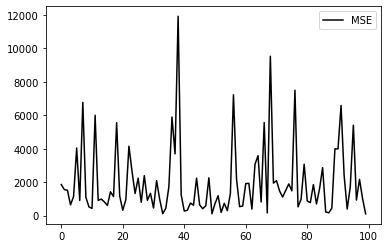

In [119]:
plt.plot(mses,c='k',label='MSE')
#plt.plot(rmses,c='red',label='RMSE')
plt.legend()
plt.show()

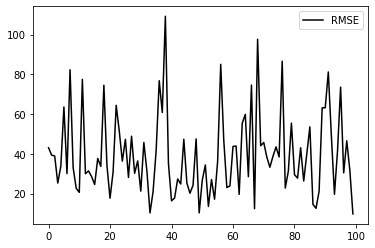

In [121]:
plt.plot(rmses,c='k',label='RMSE')
plt.legend()
plt.show()

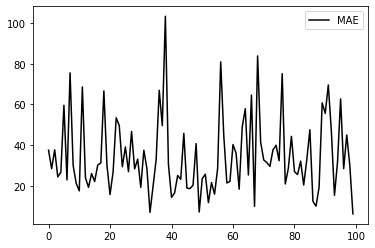

In [122]:
plt.plot(maes,c='k',label='MAE')
#plt.plot(rmses,c='red',label='RMSE')
plt.legend()
plt.show()

In [92]:
mses = np.array(mses)
rmses = np.array(rmses)
maes = np.array(maes)

print("MSE :",np.mean(mses))
print("RMSES :",np.mean(rmses))
print("MAES :",np.mean(maes))

MSE : 1962.3843992086681
RMSES : 39.34071115509717
MAES : 34.46363976563507


# <a id='testing'>4 Testing</a>
<a href='#index'>Go back to Index</a>

In [93]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [94]:
df_rul = pd.read_csv(RUL_file, names=['rul'])
df_rul.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [95]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
#max_cycles[0] = max_cycles[0] - 21

In [96]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


In [97]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

In [98]:
X_test = np.array(df_test)

y_test = np.array(df_rul)

print(X_test.shape,y_test.shape)
print(max_cycles)

(13096, 17) (100, 1)
[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [99]:
X_test_new = []
i = 0
count = 0
while i < len(X_test):
    temp_x = []
    j = int(max_cycles[count])
    count = count+1
    if j == 0:
        break
    while j!=0:
        temp_x.append(X_test[i])
        i=i+1
        j=j-1
    X_test_new.append(temp_x)

In [100]:
def create_dataset(X, look_back=20):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

In [101]:
for i in range(len(X_test_new)):
    X_test_new[i] = create_dataset(X_test_new[i])
#y_test = y_test[6:]

In [106]:
using_mean = []
using_last_index = []
predictions = []
for i in range(len(X_test_new)):
    print("-------------------------Current Engine :",i+1,"-----------------------------")
    pred = model.predict(X_test_new[i])
    using_mean.append(np.mean(pred))
    using_last_index.append(pred[-1])
    print("Actual RUL :",y_test[i])
    print("Predicted using last index :",pred[-1])
    print("Predicted using mean :",np.mean(pred))
    predictions.append(pred)

-------------------------Current Engine : 1 -----------------------------
Actual RUL : [112]
Predicted using last index : [164.42693]
Predicted using mean : 167.9404
-------------------------Current Engine : 2 -----------------------------
Actual RUL : [98]
Predicted using last index : [159.28233]
Predicted using mean : 180.16615
-------------------------Current Engine : 3 -----------------------------
Actual RUL : [69]
Predicted using last index : [37.13399]
Predicted using mean : 93.60479
-------------------------Current Engine : 4 -----------------------------
Actual RUL : [82]
Predicted using last index : [40.586914]
Predicted using mean : 127.671715
-------------------------Current Engine : 5 -----------------------------
Actual RUL : [91]
Predicted using last index : [48.59797]
Predicted using mean : 131.72755
-------------------------Current Engine : 6 -----------------------------
Actual RUL : [93]
Predicted using last index : [47.79462]
Predicted using mean : 134.8348
--------

Actual RUL : [114]
Predicted using last index : [52.16541]
Predicted using mean : 144.52574
-------------------------Current Engine : 52 -----------------------------
Actual RUL : [29]
Predicted using last index : [35.874226]
Predicted using mean : 117.86766
-------------------------Current Engine : 53 -----------------------------
Actual RUL : [26]
Predicted using last index : [36.83682]
Predicted using mean : 96.67129
-------------------------Current Engine : 54 -----------------------------
Actual RUL : [97]
Predicted using last index : [101.808846]
Predicted using mean : 141.44861
-------------------------Current Engine : 55 -----------------------------
Actual RUL : [137]
Predicted using last index : [88.85327]
Predicted using mean : 125.36105
-------------------------Current Engine : 56 -----------------------------
Actual RUL : [15]
Predicted using last index : [35.277096]
Predicted using mean : 77.51253
-------------------------Current Engine : 57 -----------------------------


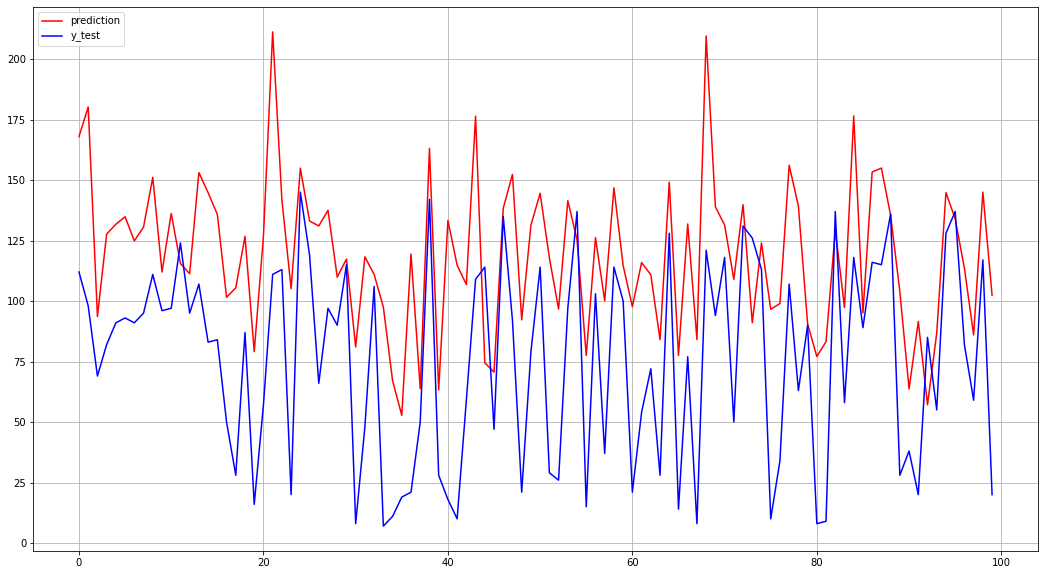

In [107]:
fig = plt.figure(figsize=(18,10))
plt.plot(using_mean,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [108]:
print("mean_squared_error >> ", mean_squared_error(y_test,using_mean))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,using_mean)))
print("mean_absolute_error >>",mean_absolute_error(y_test,using_mean))

mean_squared_error >>  2829.0344297789165
root_mean_squared_error >>  53.18866824596115
mean_absolute_error >> 45.73787055969238


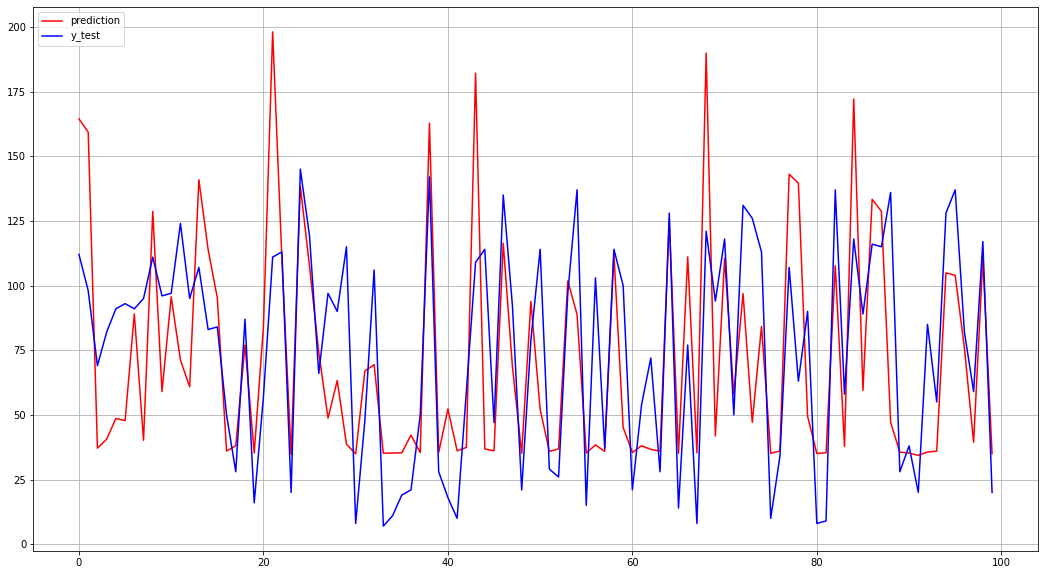

mean_squared_error >>  1262.6014436325966
root_mean_squared_error >>  35.53310349002176
mean_absolute_error >> 28.382078018188476


In [109]:
fig = plt.figure(figsize=(18,10))
plt.plot(using_last_index,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.grid()
plt.show()

print("mean_squared_error >> ", mean_squared_error(y_test,using_last_index))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,using_last_index)))
print("mean_absolute_error >>",mean_absolute_error(y_test,using_last_index))

In [110]:
a = y_test

In [111]:
my_pred = using_last_index

In [112]:
actual = []
for i in range(len(a)):
    actual.append(a[i][0])

In [113]:
print(actual)

[112, 98, 69, 82, 91, 93, 91, 95, 111, 96, 97, 124, 95, 107, 83, 84, 50, 28, 87, 16, 57, 111, 113, 20, 145, 119, 66, 97, 90, 115, 8, 48, 106, 7, 11, 19, 21, 50, 142, 28, 18, 10, 59, 109, 114, 47, 135, 92, 21, 79, 114, 29, 26, 97, 137, 15, 103, 37, 114, 100, 21, 54, 72, 28, 128, 14, 77, 8, 121, 94, 118, 50, 131, 126, 113, 10, 34, 107, 63, 90, 8, 9, 137, 58, 118, 89, 116, 115, 136, 28, 38, 20, 85, 55, 128, 137, 82, 59, 117, 20]


In [114]:
print(my_pred)

[array([164.42693], dtype=float32), array([159.28233], dtype=float32), array([37.13399], dtype=float32), array([40.586914], dtype=float32), array([48.59797], dtype=float32), array([47.79462], dtype=float32), array([89.014755], dtype=float32), array([40.17487], dtype=float32), array([128.67912], dtype=float32), array([58.983013], dtype=float32), array([95.649055], dtype=float32), array([71.16303], dtype=float32), array([60.855816], dtype=float32), array([140.938], dtype=float32), array([113.95393], dtype=float32), array([95.21439], dtype=float32), array([36.009407], dtype=float32), array([38.04605], dtype=float32), array([77.00411], dtype=float32), array([35.247547], dtype=float32), array([84.13112], dtype=float32), array([198.05652], dtype=float32), array([110.3566], dtype=float32), array([34.726017], dtype=float32), array([138.45052], dtype=float32), array([107.2687], dtype=float32), array([74.127556], dtype=float32), array([48.725597], dtype=float32), array([63.293102], dtype=float32

In [115]:
overestimation = []
percentage_errors = [[],[],[],[],[],[],[],[],[],[],[]]
for i in range(len(my_pred)):
    percentage_error = ((my_pred[i]-actual[i])/actual[i])*100
#     print(abs(int(percentage_error/10)))
    print("For engine",i,"overestimated RUL is :",percentage_error)
    if abs(int(percentage_error/10)) < 10:
        percentage_errors[abs(int(percentage_error/10))].append(percentage_error)
    else:
        percentage_errors[10].append(percentage_error)
    overestimation.append(my_pred[i]-actual[i])

For engine 0 overestimated RUL is : [46.809753]
For engine 1 overestimated RUL is : [62.53299]
For engine 2 overestimated RUL is : [-46.18262]
For engine 3 overestimated RUL is : [-50.50376]
For engine 4 overestimated RUL is : [-46.59564]
For engine 5 overestimated RUL is : [-48.607933]
For engine 6 overestimated RUL is : [-2.1815875]
For engine 7 overestimated RUL is : [-57.710667]
For engine 8 overestimated RUL is : [15.927137]
For engine 9 overestimated RUL is : [-38.55936]
For engine 10 overestimated RUL is : [-1.3927263]
For engine 11 overestimated RUL is : [-42.61046]
For engine 12 overestimated RUL is : [-35.941246]
For engine 13 overestimated RUL is : [31.71776]
For engine 14 overestimated RUL is : [37.293896]
For engine 15 overestimated RUL is : [13.350469]
For engine 16 overestimated RUL is : [-27.981186]
For engine 17 overestimated RUL is : [35.878754]
For engine 18 overestimated RUL is : [-11.489526]
For engine 19 overestimated RUL is : [120.29717]
For engine 20 overestimat

In [116]:
positive,negative,zeros = 0,0,0
for i in range(len(overestimation)):
    if overestimation[i] < 0:
        negative = negative + 1
    elif overestimation[i] > 0:
        positive = positive + 1
    else:
        zeros = zeros + 1

In [117]:
print("Overestimated RUL :",positive)
print("Underestimated RUL :",negative)
print("Correctly predicted RUL :",zeros)

Overestimated RUL : 48
Underestimated RUL : 52
Correctly predicted RUL : 0


In [118]:
for p in range(11):    
    if p < 10:
        print('Between',p*10,'and',(p+1)*10,'%','are :',len(percentage_errors[p]),'\n',percentage_errors[p],'\n\n')
    else:
        print('Over',p*10,'% are',len(percentage_errors[p]),'\n',percentage_errors[p],'\n\n')

Between 0 and 10 % are : 14 
 [array([-2.1815875], dtype=float32), array([-1.3927263], dtype=float32), array([-2.3392937], dtype=float32), array([-4.5168858], dtype=float32), array([-9.858235], dtype=float32), array([4.957573], dtype=float32), array([-3.0131056], dtype=float32), array([-1.5223386], dtype=float32), array([-1.8315017], dtype=float32), array([-6.3889256], dtype=float32), array([5.989793], dtype=float32), array([-7.280621], dtype=float32), array([-7.397805], dtype=float32), array([-5.662817], dtype=float32)] 


Between 10 and 20 % are : 11 
 [array([15.927137], dtype=float32), array([13.350469], dtype=float32), array([-11.489526], dtype=float32), array([12.314478], dtype=float32), array([14.63551], dtype=float32), array([-13.814725], dtype=float32), array([18.782053], dtype=float32), array([16.083748], dtype=float32), array([14.939749], dtype=float32), array([11.916066], dtype=float32), array([-18.046087], dtype=float32)] 


Between 20 and 30 % are : 14 
 [array([-27.98118